In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()

In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
#!ls /Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/development_mavenn2/Titeseq_16

In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-08 23:35:58.535206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize at discrete monotonic GP map

In [9]:
gpmap.set_params()
theta_0_init = np.load('models/theta_0_DM.npy')
theta_lc_init = np.load('models/theta_lc_DM.npy')

init_params_dict = {'theta_0':theta_0_init, 'theta_lc':theta_lc_init}
#gpmap.set_params(**init_params_dict)

In [10]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [11]:
print(N_y[0:10])

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
dtype: int64


#### I obtained these values from Fig 3's script

In [12]:
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, np.log10(3e4)]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, np.log10(1e5)]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,np.log10(3e4)]])

aff_gates = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]

In [13]:
np.mean(np.array(aff_gates),axis=0)

array([[1.4775788 , 2.23034631],
       [2.23612365, 2.88471283],
       [2.88964045, 3.53840761],
       [3.54581157, 4.65141417]])

In [14]:
#bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds = np.mean(np.array(aff_gates),axis=0)
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,1.477579,2.230346
1,2.236124,2.884713
2,2.889640,3.538408
3,3.545812,4.651414


In [15]:
# mu_neg = np.log(200)
# mu_pos = np.log(9000)

#mu_neg = np.log(1.2)
mu_neg = np.log10(200)
#mu_neg = np.log(50)
mu_pos = np.log10(9000)

sigma_neg = 2.0
sigma_pos = 2.0

In [16]:
mu_neg, mu_pos

(2.3010299956639813, 3.9542425094393248)

In [17]:
np.log(20000), np.log(10)

(9.903487552536127, 2.302585092994046)

In [18]:
f_y_upper_bounds

array([2.23034631, 2.88471283, 3.53840761, 4.65141417])

In [19]:
#np.arange(10**(-13),10**(-6),10**(-12))
cs = [0,10**(-9.5),
     10**(-9),10**(-8.5),
     10**(-8),10**(-7.5),
     10**(-7),10**(-6.5),
     10**(-6),10**(-5.5),
     10**(-5),]

# cs = np.arange(0.1,1,0.085)
#cs = np.array(cs)*(10**6)

In [20]:
TiteSeq_mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
                                                         c=cs[mp_idx],
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-10,)
           for mp_idx in range(len(y_cols)//4)
          ]

In [21]:
len(TiteSeq_mp_list)

11

In [22]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=TiteSeq_mp_list)

In [23]:
#model.model.summary()

In [24]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 20.8% for validation.
Time to set data: 0.958 sec.


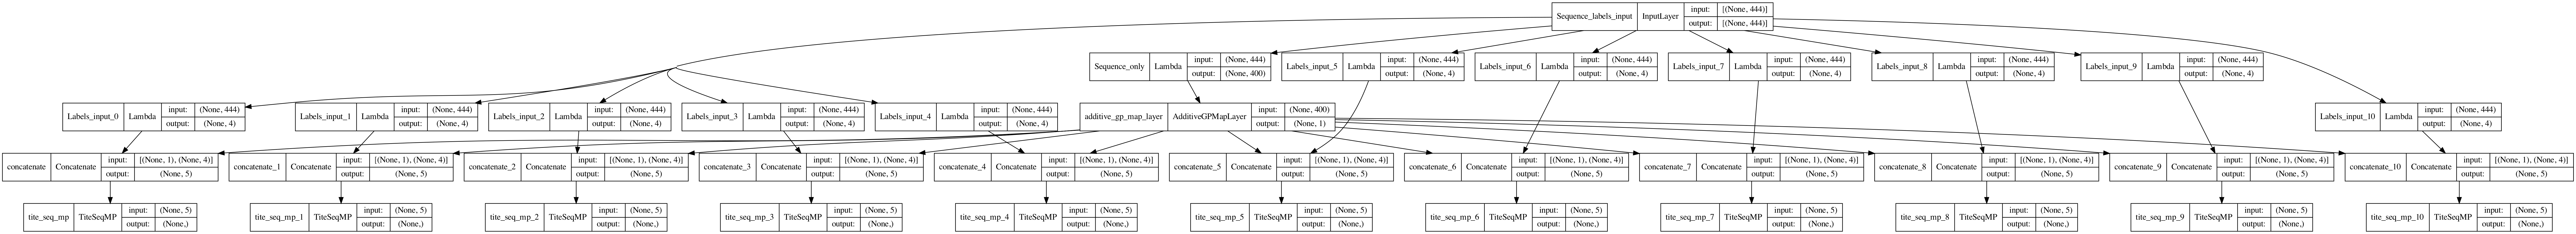

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='pngs/Titeseq_MP/titeseq16_TSMP.png')


In [26]:

# Fit model to data
model.fit(learning_rate=.0003,
          epochs=1000,
          batch_size=200,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/1000
42/42 [==============================] - 21s 88ms/step - loss: 6507514.5000 - tite_seq_mp_loss: 507764.0312 - tite_seq_mp_1_loss: 552579.0625 - tite_seq_mp_2_loss: 951392.6875 - tite_seq_mp_3_loss: 632404.2500 - tite_seq_mp_4_loss: 463419.0625 - tite_seq_mp_5_loss: 239511.6719 - tite_seq_mp_6_loss: 308508.9062 - tite_seq_mp_7_loss: 640609.9375 - tite_seq_mp_8_loss: 576118.5000 - tite_seq_mp_9_loss: 888983.4375 - tite_seq_mp_10_loss: 746222.5625 - I_var: -0.1155 - val_loss: 9319400.0000 - val_tite_seq_mp_loss: 584668.0625 - val_tite_seq_mp_1_loss: 822568.3125 - val_tite_seq_mp_2_loss: 1244224.8750 - val_tite_seq_mp_3_loss: 881393.2500 - val_tite_seq_mp_4_loss: 651164.2500 - val_tite_seq_mp_5_loss: 400706.9688 - val_tite_seq_mp_6_loss: 423636.0625 - val_tite_seq_mp_7_loss: 1897753.1250 - val_tite_seq_mp_8_loss: 691772.0625 - val_tite_seq_mp_9_loss: 845862.1875 - val_tite_seq_mp_10_loss: 875650.9375 - val_I_var: -0.1074
Epoch 2/1000
42/42 [==============================] - 1s

Epoch 10/1000
42/42 [==============================] - 0s 12ms/step - loss: 6504585.5000 - tite_seq_mp_loss: 507426.2188 - tite_seq_mp_1_loss: 552361.3125 - tite_seq_mp_2_loss: 950717.0625 - tite_seq_mp_3_loss: 632118.3125 - tite_seq_mp_4_loss: 462935.6250 - tite_seq_mp_5_loss: 239710.0625 - tite_seq_mp_6_loss: 308393.3750 - tite_seq_mp_7_loss: 640666.0000 - tite_seq_mp_8_loss: 575965.8125 - tite_seq_mp_9_loss: 888283.7500 - tite_seq_mp_10_loss: 746008.6875 - I_var: -0.1148 - val_loss: 9316688.0000 - val_tite_seq_mp_loss: 584670.4375 - val_tite_seq_mp_1_loss: 822370.2500 - val_tite_seq_mp_2_loss: 1243739.1250 - val_tite_seq_mp_3_loss: 881156.6875 - val_tite_seq_mp_4_loss: 650891.5625 - val_tite_seq_mp_5_loss: 400549.5938 - val_tite_seq_mp_6_loss: 423565.8750 - val_tite_seq_mp_7_loss: 1896958.5000 - val_tite_seq_mp_8_loss: 691578.6250 - val_tite_seq_mp_9_loss: 845751.2500 - val_tite_seq_mp_10_loss: 875456.6875 - val_I_var: -0.1073
Epoch 11/1000
42/42 [==============================] - 0

Epoch 19/1000
42/42 [==============================] - 0s 10ms/step - loss: 6503131.0000 - tite_seq_mp_loss: 507363.4062 - tite_seq_mp_1_loss: 552262.0000 - tite_seq_mp_2_loss: 950702.1250 - tite_seq_mp_3_loss: 632173.8125 - tite_seq_mp_4_loss: 462989.0938 - tite_seq_mp_5_loss: 239673.2188 - tite_seq_mp_6_loss: 308316.2500 - tite_seq_mp_7_loss: 639904.1875 - tite_seq_mp_8_loss: 575704.4375 - tite_seq_mp_9_loss: 888237.8750 - tite_seq_mp_10_loss: 745804.6250 - I_var: -0.1166 - val_loss: 9315242.0000 - val_tite_seq_mp_loss: 584665.7500 - val_tite_seq_mp_1_loss: 822256.8125 - val_tite_seq_mp_2_loss: 1243457.5000 - val_tite_seq_mp_3_loss: 881046.0625 - val_tite_seq_mp_4_loss: 650750.9375 - val_tite_seq_mp_5_loss: 400454.0000 - val_tite_seq_mp_6_loss: 423526.7812 - val_tite_seq_mp_7_loss: 1896535.0000 - val_tite_seq_mp_8_loss: 691490.1875 - val_tite_seq_mp_9_loss: 845687.6875 - val_tite_seq_mp_10_loss: 875371.3750 - val_I_var: -0.1072
Epoch 20/1000
42/42 [==============================] - 0

Epoch 28/1000
42/42 [==============================] - 0s 11ms/step - loss: 6500285.5000 - tite_seq_mp_loss: 507087.0000 - tite_seq_mp_1_loss: 552066.5625 - tite_seq_mp_2_loss: 950216.6875 - tite_seq_mp_3_loss: 631597.8125 - tite_seq_mp_4_loss: 462781.1875 - tite_seq_mp_5_loss: 239634.2656 - tite_seq_mp_6_loss: 308139.8750 - tite_seq_mp_7_loss: 640335.8125 - tite_seq_mp_8_loss: 575515.2500 - tite_seq_mp_9_loss: 887325.7500 - tite_seq_mp_10_loss: 745584.6250 - I_var: -0.1150 - val_loss: 9314133.0000 - val_tite_seq_mp_loss: 584660.2500 - val_tite_seq_mp_1_loss: 822162.8750 - val_tite_seq_mp_2_loss: 1243228.2500 - val_tite_seq_mp_3_loss: 880968.0625 - val_tite_seq_mp_4_loss: 650644.3125 - val_tite_seq_mp_5_loss: 400374.6562 - val_tite_seq_mp_6_loss: 423496.1562 - val_tite_seq_mp_7_loss: 1896212.7500 - val_tite_seq_mp_8_loss: 691432.4375 - val_tite_seq_mp_9_loss: 845635.5625 - val_tite_seq_mp_10_loss: 875316.8125 - val_I_var: -0.1072
Epoch 29/1000
42/42 [==============================] - 0

Epoch 37/1000
42/42 [==============================] - 0s 12ms/step - loss: 6096943.0000 - tite_seq_mp_loss: 463876.5625 - tite_seq_mp_1_loss: 511809.2500 - tite_seq_mp_2_loss: 877751.7500 - tite_seq_mp_3_loss: 560308.9375 - tite_seq_mp_4_loss: 426651.5938 - tite_seq_mp_5_loss: 235680.0156 - tite_seq_mp_6_loss: 298334.0938 - tite_seq_mp_7_loss: 612161.3750 - tite_seq_mp_8_loss: 547086.2500 - tite_seq_mp_9_loss: 850942.7500 - tite_seq_mp_10_loss: 712339.8125 - I_var: -0.1139 - val_loss: 9313080.0000 - val_tite_seq_mp_loss: 584655.5000 - val_tite_seq_mp_1_loss: 822071.8750 - val_tite_seq_mp_2_loss: 1243001.8750 - val_tite_seq_mp_3_loss: 880901.6250 - val_tite_seq_mp_4_loss: 650546.8750 - val_tite_seq_mp_5_loss: 400294.0625 - val_tite_seq_mp_6_loss: 423466.5625 - val_tite_seq_mp_7_loss: 1895904.7500 - val_tite_seq_mp_8_loss: 691381.3750 - val_tite_seq_mp_9_loss: 845585.0000 - val_tite_seq_mp_10_loss: 875270.6250 - val_I_var: -0.1072
Epoch 38/1000
42/42 [==============================] - 0

Epoch 46/1000
42/42 [==============================] - 0s 11ms/step - loss: 6453884.5000 - tite_seq_mp_loss: 506446.5625 - tite_seq_mp_1_loss: 551606.6875 - tite_seq_mp_2_loss: 948915.8750 - tite_seq_mp_3_loss: 631509.0000 - tite_seq_mp_4_loss: 462206.2188 - tite_seq_mp_5_loss: 239343.3750 - tite_seq_mp_6_loss: 307348.9375 - tite_seq_mp_7_loss: 638741.6250 - tite_seq_mp_8_loss: 573477.5625 - tite_seq_mp_9_loss: 854675.3750 - tite_seq_mp_10_loss: 739614.1875 - I_var: -0.1159 - val_loss: 9311887.0000 - val_tite_seq_mp_loss: 584650.4375 - val_tite_seq_mp_1_loss: 821963.8750 - val_tite_seq_mp_2_loss: 1242739.3750 - val_tite_seq_mp_3_loss: 880825.8125 - val_tite_seq_mp_4_loss: 650434.9375 - val_tite_seq_mp_5_loss: 400200.7812 - val_tite_seq_mp_6_loss: 423432.8750 - val_tite_seq_mp_7_loss: 1895561.5000 - val_tite_seq_mp_8_loss: 691328.1250 - val_tite_seq_mp_9_loss: 845528.3750 - val_tite_seq_mp_10_loss: 875221.2500 - val_I_var: -0.1072
Epoch 47/1000
42/42 [==============================] - 0

Epoch 55/1000
42/42 [==============================] - 0s 12ms/step - loss: 6498204.5000 - tite_seq_mp_loss: 506638.1875 - tite_seq_mp_1_loss: 551864.6250 - tite_seq_mp_2_loss: 949887.7500 - tite_seq_mp_3_loss: 631394.2500 - tite_seq_mp_4_loss: 462507.1250 - tite_seq_mp_5_loss: 239642.9219 - tite_seq_mp_6_loss: 308276.4375 - tite_seq_mp_7_loss: 640324.7500 - tite_seq_mp_8_loss: 575570.3750 - tite_seq_mp_9_loss: 886484.0625 - tite_seq_mp_10_loss: 745613.2500 - I_var: -0.1150 - val_loss: 9310578.0000 - val_tite_seq_mp_loss: 584645.6250 - val_tite_seq_mp_1_loss: 821844.2500 - val_tite_seq_mp_2_loss: 1242445.6250 - val_tite_seq_mp_3_loss: 880748.4375 - val_tite_seq_mp_4_loss: 650314.8750 - val_tite_seq_mp_5_loss: 400094.6250 - val_tite_seq_mp_6_loss: 423395.5312 - val_tite_seq_mp_7_loss: 1895184.3750 - val_tite_seq_mp_8_loss: 691271.7500 - val_tite_seq_mp_9_loss: 845462.9375 - val_tite_seq_mp_10_loss: 875169.6875 - val_I_var: -0.1071
Epoch 56/1000
42/42 [==============================] - 0

Epoch 64/1000
42/42 [==============================] - 1s 12ms/step - loss: 6501766.5000 - tite_seq_mp_loss: 506567.9062 - tite_seq_mp_1_loss: 551917.7500 - tite_seq_mp_2_loss: 949899.0625 - tite_seq_mp_3_loss: 631431.2500 - tite_seq_mp_4_loss: 462742.9062 - tite_seq_mp_5_loss: 239656.5469 - tite_seq_mp_6_loss: 308205.4688 - tite_seq_mp_7_loss: 640755.0625 - tite_seq_mp_8_loss: 575839.0625 - tite_seq_mp_9_loss: 888219.8750 - tite_seq_mp_10_loss: 746532.1875 - I_var: -0.1144 - val_loss: 9309174.0000 - val_tite_seq_mp_loss: 584642.3750 - val_tite_seq_mp_1_loss: 821712.6875 - val_tite_seq_mp_2_loss: 1242122.2500 - val_tite_seq_mp_3_loss: 880669.2500 - val_tite_seq_mp_4_loss: 650188.1875 - val_tite_seq_mp_5_loss: 399976.0312 - val_tite_seq_mp_6_loss: 423355.2500 - val_tite_seq_mp_7_loss: 1894782.8750 - val_tite_seq_mp_8_loss: 691214.7500 - val_tite_seq_mp_9_loss: 845392.7500 - val_tite_seq_mp_10_loss: 875117.7500 - val_I_var: -0.1071
Epoch 65/1000
42/42 [==============================] - 1

Epoch 73/1000
42/42 [==============================] - 0s 10ms/step - loss: 6501689.5000 - tite_seq_mp_loss: 506573.7188 - tite_seq_mp_1_loss: 552087.5000 - tite_seq_mp_2_loss: 949864.4375 - tite_seq_mp_3_loss: 631891.6250 - tite_seq_mp_4_loss: 462882.4062 - tite_seq_mp_5_loss: 239608.3438 - tite_seq_mp_6_loss: 308172.8750 - tite_seq_mp_7_loss: 640599.1250 - tite_seq_mp_8_loss: 575823.4375 - tite_seq_mp_9_loss: 887886.8125 - tite_seq_mp_10_loss: 746299.8125 - I_var: -0.1150 - val_loss: 9307541.0000 - val_tite_seq_mp_loss: 584641.8125 - val_tite_seq_mp_1_loss: 821557.4375 - val_tite_seq_mp_2_loss: 1241739.1250 - val_tite_seq_mp_3_loss: 880578.5000 - val_tite_seq_mp_4_loss: 650041.0625 - val_tite_seq_mp_5_loss: 399835.2500 - val_tite_seq_mp_6_loss: 423308.0938 - val_tite_seq_mp_7_loss: 1894319.1250 - val_tite_seq_mp_8_loss: 691150.0000 - val_tite_seq_mp_9_loss: 845311.8750 - val_tite_seq_mp_10_loss: 875058.5625 - val_I_var: -0.1071
Epoch 74/1000
42/42 [==============================] - 0

Epoch 82/1000
42/42 [==============================] - 0s 11ms/step - loss: 6500011.5000 - tite_seq_mp_loss: 506264.5938 - tite_seq_mp_1_loss: 551783.8125 - tite_seq_mp_2_loss: 949628.8125 - tite_seq_mp_3_loss: 631472.8125 - tite_seq_mp_4_loss: 462586.6562 - tite_seq_mp_5_loss: 239692.1094 - tite_seq_mp_6_loss: 308258.5312 - tite_seq_mp_7_loss: 640383.7500 - tite_seq_mp_8_loss: 575746.1875 - tite_seq_mp_9_loss: 887988.0000 - tite_seq_mp_10_loss: 746205.0000 - I_var: -0.1144 - val_loss: 9305669.0000 - val_tite_seq_mp_loss: 584647.3750 - val_tite_seq_mp_1_loss: 821376.4375 - val_tite_seq_mp_2_loss: 1241292.6250 - val_tite_seq_mp_3_loss: 880474.5000 - val_tite_seq_mp_4_loss: 649872.1875 - val_tite_seq_mp_5_loss: 399669.6875 - val_tite_seq_mp_6_loss: 423253.7812 - val_tite_seq_mp_7_loss: 1893793.2500 - val_tite_seq_mp_8_loss: 691078.6875 - val_tite_seq_mp_9_loss: 845217.8750 - val_tite_seq_mp_10_loss: 874992.0000 - val_I_var: -0.1070
Epoch 83/1000
42/42 [==============================] - 0

Epoch 91/1000
42/42 [==============================] - 0s 11ms/step - loss: 6491447.5000 - tite_seq_mp_loss: 505945.5312 - tite_seq_mp_1_loss: 551376.1250 - tite_seq_mp_2_loss: 948521.2500 - tite_seq_mp_3_loss: 631219.3125 - tite_seq_mp_4_loss: 462111.1875 - tite_seq_mp_5_loss: 239387.4844 - tite_seq_mp_6_loss: 307912.2812 - tite_seq_mp_7_loss: 639460.0000 - tite_seq_mp_8_loss: 575001.7500 - tite_seq_mp_9_loss: 885725.0000 - tite_seq_mp_10_loss: 744788.3125 - I_var: -0.1145 - val_loss: 9303586.0000 - val_tite_seq_mp_loss: 584667.4375 - val_tite_seq_mp_1_loss: 821174.3125 - val_tite_seq_mp_2_loss: 1240785.0000 - val_tite_seq_mp_3_loss: 880361.2500 - val_tite_seq_mp_4_loss: 649687.0625 - val_tite_seq_mp_5_loss: 399478.0000 - val_tite_seq_mp_6_loss: 423192.9688 - val_tite_seq_mp_7_loss: 1893210.5000 - val_tite_seq_mp_8_loss: 691000.8750 - val_tite_seq_mp_9_loss: 845109.5625 - val_tite_seq_mp_10_loss: 874919.4375 - val_I_var: -0.1070
Epoch 92/1000
42/42 [==============================] - 0

Epoch 100/1000
42/42 [==============================] - 0s 11ms/step - loss: 6491142.5000 - tite_seq_mp_loss: 505843.3125 - tite_seq_mp_1_loss: 551357.5625 - tite_seq_mp_2_loss: 948732.3125 - tite_seq_mp_3_loss: 630932.0000 - tite_seq_mp_4_loss: 462080.8438 - tite_seq_mp_5_loss: 239144.4688 - tite_seq_mp_6_loss: 307820.8438 - tite_seq_mp_7_loss: 638434.3750 - tite_seq_mp_8_loss: 575182.5625 - tite_seq_mp_9_loss: 886831.3750 - tite_seq_mp_10_loss: 744783.3125 - I_var: -0.1132 - val_loss: 9301282.0000 - val_tite_seq_mp_loss: 584713.5625 - val_tite_seq_mp_1_loss: 820947.2500 - val_tite_seq_mp_2_loss: 1240205.1250 - val_tite_seq_mp_3_loss: 880236.1875 - val_tite_seq_mp_4_loss: 649482.4375 - val_tite_seq_mp_5_loss: 399257.0000 - val_tite_seq_mp_6_loss: 423124.6250 - val_tite_seq_mp_7_loss: 1892574.6250 - val_tite_seq_mp_8_loss: 690916.6250 - val_tite_seq_mp_9_loss: 844985.5625 - val_tite_seq_mp_10_loss: 874838.9375 - val_I_var: -0.1069
Epoch 101/1000
42/42 [==============================] -

Epoch 109/1000
42/42 [==============================] - 0s 11ms/step - loss: 6495589.0000 - tite_seq_mp_loss: 505776.6562 - tite_seq_mp_1_loss: 551425.3750 - tite_seq_mp_2_loss: 948918.3750 - tite_seq_mp_3_loss: 630898.4375 - tite_seq_mp_4_loss: 462365.7500 - tite_seq_mp_5_loss: 239505.3594 - tite_seq_mp_6_loss: 307972.3750 - tite_seq_mp_7_loss: 640026.0000 - tite_seq_mp_8_loss: 575713.9375 - tite_seq_mp_9_loss: 887046.8125 - tite_seq_mp_10_loss: 745940.8750 - I_var: -0.1145 - val_loss: 9298625.0000 - val_tite_seq_mp_loss: 584778.4375 - val_tite_seq_mp_1_loss: 820684.9375 - val_tite_seq_mp_2_loss: 1239528.1250 - val_tite_seq_mp_3_loss: 880094.2500 - val_tite_seq_mp_4_loss: 649247.3125 - val_tite_seq_mp_5_loss: 398993.0000 - val_tite_seq_mp_6_loss: 423046.1875 - val_tite_seq_mp_7_loss: 1891839.1250 - val_tite_seq_mp_8_loss: 690821.3750 - val_tite_seq_mp_9_loss: 844844.3125 - val_tite_seq_mp_10_loss: 874748.6250 - val_I_var: -0.1068
Epoch 110/1000
42/42 [==============================] -

Epoch 118/1000
42/42 [==============================] - 0s 11ms/step - loss: 6485353.0000 - tite_seq_mp_loss: 505014.2812 - tite_seq_mp_1_loss: 550916.5625 - tite_seq_mp_2_loss: 947727.8125 - tite_seq_mp_3_loss: 630636.3750 - tite_seq_mp_4_loss: 461912.1875 - tite_seq_mp_5_loss: 239022.4844 - tite_seq_mp_6_loss: 307645.0312 - tite_seq_mp_7_loss: 637915.8750 - tite_seq_mp_8_loss: 574790.9375 - tite_seq_mp_9_loss: 884888.3750 - tite_seq_mp_10_loss: 744883.8750 - I_var: -0.1143 - val_loss: 9295552.0000 - val_tite_seq_mp_loss: 584855.1875 - val_tite_seq_mp_1_loss: 820378.1875 - val_tite_seq_mp_2_loss: 1238731.5000 - val_tite_seq_mp_3_loss: 879937.4375 - val_tite_seq_mp_4_loss: 648976.1250 - val_tite_seq_mp_5_loss: 398678.4062 - val_tite_seq_mp_6_loss: 422955.7812 - val_tite_seq_mp_7_loss: 1890993.0000 - val_tite_seq_mp_8_loss: 690714.5000 - val_tite_seq_mp_9_loss: 844684.6250 - val_tite_seq_mp_10_loss: 874647.9375 - val_I_var: -0.1067
Epoch 119/1000
42/42 [==============================] -

Epoch 127/1000
42/42 [==============================] - 1s 12ms/step - loss: 6471172.5000 - tite_seq_mp_loss: 497041.5938 - tite_seq_mp_1_loss: 551097.5625 - tite_seq_mp_2_loss: 947924.3125 - tite_seq_mp_3_loss: 631109.0000 - tite_seq_mp_4_loss: 461896.9688 - tite_seq_mp_5_loss: 238849.3750 - tite_seq_mp_6_loss: 307677.8438 - tite_seq_mp_7_loss: 637039.2500 - tite_seq_mp_8_loss: 575255.6875 - tite_seq_mp_9_loss: 879257.1875 - tite_seq_mp_10_loss: 744023.0625 - I_var: -0.1166 - val_loss: 9292133.0000 - val_tite_seq_mp_loss: 584956.6250 - val_tite_seq_mp_1_loss: 820030.5000 - val_tite_seq_mp_2_loss: 1237827.2500 - val_tite_seq_mp_3_loss: 879764.0625 - val_tite_seq_mp_4_loss: 648674.3125 - val_tite_seq_mp_5_loss: 398316.0000 - val_tite_seq_mp_6_loss: 422855.9062 - val_tite_seq_mp_7_loss: 1890062.8750 - val_tite_seq_mp_8_loss: 690602.1875 - val_tite_seq_mp_9_loss: 844502.4375 - val_tite_seq_mp_10_loss: 874541.4375 - val_I_var: -0.1065
Epoch 128/1000
42/42 [==============================] -

Epoch 136/1000
42/42 [==============================] - 1s 12ms/step - loss: 6487399.0000 - tite_seq_mp_loss: 504752.7188 - tite_seq_mp_1_loss: 550569.5000 - tite_seq_mp_2_loss: 947091.5000 - tite_seq_mp_3_loss: 630627.8750 - tite_seq_mp_4_loss: 461921.5000 - tite_seq_mp_5_loss: 239039.9375 - tite_seq_mp_6_loss: 307622.6250 - tite_seq_mp_7_loss: 639340.4375 - tite_seq_mp_8_loss: 575382.5625 - tite_seq_mp_9_loss: 885728.5625 - tite_seq_mp_10_loss: 745321.4375 - I_var: -0.1158 - val_loss: 9288126.0000 - val_tite_seq_mp_loss: 585069.9375 - val_tite_seq_mp_1_loss: 819629.4375 - val_tite_seq_mp_2_loss: 1236763.6250 - val_tite_seq_mp_3_loss: 879576.1875 - val_tite_seq_mp_4_loss: 648330.7500 - val_tite_seq_mp_5_loss: 397877.4375 - val_tite_seq_mp_6_loss: 422740.0312 - val_tite_seq_mp_7_loss: 1888953.8750 - val_tite_seq_mp_8_loss: 690472.6875 - val_tite_seq_mp_9_loss: 844292.6875 - val_tite_seq_mp_10_loss: 874420.9375 - val_I_var: -0.1064
Epoch 137/1000
42/42 [==============================] -

Epoch 145/1000
42/42 [==============================] - 1s 13ms/step - loss: 6487095.0000 - tite_seq_mp_loss: 504181.1875 - tite_seq_mp_1_loss: 550902.1250 - tite_seq_mp_2_loss: 947050.9375 - tite_seq_mp_3_loss: 631042.8750 - tite_seq_mp_4_loss: 461779.5625 - tite_seq_mp_5_loss: 238955.8594 - tite_seq_mp_6_loss: 307592.4062 - tite_seq_mp_7_loss: 638879.8750 - tite_seq_mp_8_loss: 575567.1250 - tite_seq_mp_9_loss: 885484.5000 - tite_seq_mp_10_loss: 745659.2500 - I_var: -0.1125 - val_loss: 9283668.0000 - val_tite_seq_mp_loss: 585216.5000 - val_tite_seq_mp_1_loss: 819172.8125 - val_tite_seq_mp_2_loss: 1235557.5000 - val_tite_seq_mp_3_loss: 879363.6875 - val_tite_seq_mp_4_loss: 647945.6875 - val_tite_seq_mp_5_loss: 397374.5312 - val_tite_seq_mp_6_loss: 422611.8125 - val_tite_seq_mp_7_loss: 1887738.8750 - val_tite_seq_mp_8_loss: 690336.3125 - val_tite_seq_mp_9_loss: 844056.9375 - val_tite_seq_mp_10_loss: 874292.9375 - val_I_var: -0.1063
Epoch 146/1000
42/42 [==============================] -

Epoch 154/1000
42/42 [==============================] - 1s 13ms/step - loss: 6469653.0000 - tite_seq_mp_loss: 503002.2812 - tite_seq_mp_1_loss: 549398.6250 - tite_seq_mp_2_loss: 944210.4375 - tite_seq_mp_3_loss: 629715.0000 - tite_seq_mp_4_loss: 461058.6875 - tite_seq_mp_5_loss: 238420.3438 - tite_seq_mp_6_loss: 306811.7500 - tite_seq_mp_7_loss: 636189.7500 - tite_seq_mp_8_loss: 573950.6875 - tite_seq_mp_9_loss: 883164.3125 - tite_seq_mp_10_loss: 743731.5000 - I_var: -0.1146 - val_loss: 9278745.0000 - val_tite_seq_mp_loss: 585396.5000 - val_tite_seq_mp_1_loss: 818668.9375 - val_tite_seq_mp_2_loss: 1234207.8750 - val_tite_seq_mp_3_loss: 879135.9375 - val_tite_seq_mp_4_loss: 647527.3750 - val_tite_seq_mp_5_loss: 396798.1562 - val_tite_seq_mp_6_loss: 422471.0625 - val_tite_seq_mp_7_loss: 1886392.2500 - val_tite_seq_mp_8_loss: 690189.8125 - val_tite_seq_mp_9_loss: 843799.5625 - val_tite_seq_mp_10_loss: 874157.3750 - val_I_var: -0.1061
Epoch 155/1000
42/42 [==============================] -

Epoch 163/1000
42/42 [==============================] - 0s 11ms/step - loss: 6472895.5000 - tite_seq_mp_loss: 503042.8125 - tite_seq_mp_1_loss: 549387.8125 - tite_seq_mp_2_loss: 944302.6250 - tite_seq_mp_3_loss: 629372.0000 - tite_seq_mp_4_loss: 460898.7812 - tite_seq_mp_5_loss: 238495.9688 - tite_seq_mp_6_loss: 306889.3125 - tite_seq_mp_7_loss: 637531.5625 - tite_seq_mp_8_loss: 574415.9375 - tite_seq_mp_9_loss: 883722.8125 - tite_seq_mp_10_loss: 744835.0000 - I_var: -0.1138 - val_loss: 9272837.0000 - val_tite_seq_mp_loss: 585591.8125 - val_tite_seq_mp_1_loss: 818068.0000 - val_tite_seq_mp_2_loss: 1232583.2500 - val_tite_seq_mp_3_loss: 878879.3750 - val_tite_seq_mp_4_loss: 647032.3125 - val_tite_seq_mp_5_loss: 396094.6562 - val_tite_seq_mp_6_loss: 422303.5000 - val_tite_seq_mp_7_loss: 1884763.2500 - val_tite_seq_mp_8_loss: 690018.8750 - val_tite_seq_mp_9_loss: 843500.1875 - val_tite_seq_mp_10_loss: 874000.6250 - val_I_var: -0.1060
Epoch 164/1000
42/42 [==============================] -

Epoch 172/1000
42/42 [==============================] - 0s 11ms/step - loss: 6474132.5000 - tite_seq_mp_loss: 502748.3750 - tite_seq_mp_1_loss: 549766.8125 - tite_seq_mp_2_loss: 944105.0625 - tite_seq_mp_3_loss: 630320.3125 - tite_seq_mp_4_loss: 461272.1562 - tite_seq_mp_5_loss: 238518.2500 - tite_seq_mp_6_loss: 307076.7812 - tite_seq_mp_7_loss: 637913.8750 - tite_seq_mp_8_loss: 574881.5000 - tite_seq_mp_9_loss: 882609.5625 - tite_seq_mp_10_loss: 744919.0625 - I_var: -0.1113 - val_loss: 9266305.0000 - val_tite_seq_mp_loss: 585852.2500 - val_tite_seq_mp_1_loss: 817391.8125 - val_tite_seq_mp_2_loss: 1230752.6250 - val_tite_seq_mp_3_loss: 878598.3750 - val_tite_seq_mp_4_loss: 646483.1250 - val_tite_seq_mp_5_loss: 395293.0625 - val_tite_seq_mp_6_loss: 422118.7812 - val_tite_seq_mp_7_loss: 1882981.7500 - val_tite_seq_mp_8_loss: 689837.9375 - val_tite_seq_mp_9_loss: 843162.6875 - val_tite_seq_mp_10_loss: 873832.5625 - val_I_var: -0.1058
Epoch 173/1000
42/42 [==============================] -

Epoch 181/1000
42/42 [==============================] - 0s 11ms/step - loss: 6473998.0000 - tite_seq_mp_loss: 502278.3125 - tite_seq_mp_1_loss: 549383.8750 - tite_seq_mp_2_loss: 943619.6250 - tite_seq_mp_3_loss: 630180.9375 - tite_seq_mp_4_loss: 461190.3750 - tite_seq_mp_5_loss: 238083.8438 - tite_seq_mp_6_loss: 306932.3438 - tite_seq_mp_7_loss: 637996.2500 - tite_seq_mp_8_loss: 575243.7500 - tite_seq_mp_9_loss: 883368.9375 - tite_seq_mp_10_loss: 745719.0000 - I_var: -0.1133 - val_loss: 9259023.0000 - val_tite_seq_mp_loss: 586167.4375 - val_tite_seq_mp_1_loss: 816633.6250 - val_tite_seq_mp_2_loss: 1228680.0000 - val_tite_seq_mp_3_loss: 878296.6875 - val_tite_seq_mp_4_loss: 645874.0000 - val_tite_seq_mp_5_loss: 394375.6875 - val_tite_seq_mp_6_loss: 421913.1562 - val_tite_seq_mp_7_loss: 1880988.8750 - val_tite_seq_mp_8_loss: 689641.7500 - val_tite_seq_mp_9_loss: 842799.5625 - val_tite_seq_mp_10_loss: 873651.7500 - val_I_var: -0.1056
Epoch 182/1000
42/42 [==============================] -

Epoch 190/1000
42/42 [==============================] - 0s 11ms/step - loss: 6463153.0000 - tite_seq_mp_loss: 501241.1562 - tite_seq_mp_1_loss: 548396.1250 - tite_seq_mp_2_loss: 941808.9375 - tite_seq_mp_3_loss: 629253.2500 - tite_seq_mp_4_loss: 460446.0625 - tite_seq_mp_5_loss: 237623.6094 - tite_seq_mp_6_loss: 306407.0000 - tite_seq_mp_7_loss: 636648.8125 - tite_seq_mp_8_loss: 574795.9375 - tite_seq_mp_9_loss: 881772.0625 - tite_seq_mp_10_loss: 744759.7500 - I_var: -0.1137 - val_loss: 9250680.0000 - val_tite_seq_mp_loss: 586533.2500 - val_tite_seq_mp_1_loss: 815740.1875 - val_tite_seq_mp_2_loss: 1226286.5000 - val_tite_seq_mp_3_loss: 877942.0625 - val_tite_seq_mp_4_loss: 645164.2500 - val_tite_seq_mp_5_loss: 393313.6250 - val_tite_seq_mp_6_loss: 421680.0312 - val_tite_seq_mp_7_loss: 1878743.7500 - val_tite_seq_mp_8_loss: 689430.5625 - val_tite_seq_mp_9_loss: 842392.0625 - val_tite_seq_mp_10_loss: 873453.9375 - val_I_var: -0.1054
Epoch 191/1000
42/42 [==============================] -

Epoch 199/1000
42/42 [==============================] - 0s 11ms/step - loss: 6454429.0000 - tite_seq_mp_loss: 500527.7500 - tite_seq_mp_1_loss: 547703.1875 - tite_seq_mp_2_loss: 940205.7500 - tite_seq_mp_3_loss: 629256.8750 - tite_seq_mp_4_loss: 460021.9375 - tite_seq_mp_5_loss: 237312.0000 - tite_seq_mp_6_loss: 306245.6250 - tite_seq_mp_7_loss: 635316.8750 - tite_seq_mp_8_loss: 574199.8125 - tite_seq_mp_9_loss: 879888.5000 - tite_seq_mp_10_loss: 743751.8125 - I_var: -0.1137 - val_loss: 9241430.0000 - val_tite_seq_mp_loss: 587005.3750 - val_tite_seq_mp_1_loss: 814750.6875 - val_tite_seq_mp_2_loss: 1223593.3750 - val_tite_seq_mp_3_loss: 877561.3125 - val_tite_seq_mp_4_loss: 644382.2500 - val_tite_seq_mp_5_loss: 392109.8750 - val_tite_seq_mp_6_loss: 421421.0625 - val_tite_seq_mp_7_loss: 1876249.7500 - val_tite_seq_mp_8_loss: 689199.0000 - val_tite_seq_mp_9_loss: 841921.6875 - val_tite_seq_mp_10_loss: 873236.2500 - val_I_var: -0.1052
Epoch 200/1000
42/42 [==============================] -

Epoch 208/1000
42/42 [==============================] - 1s 13ms/step - loss: 6459154.0000 - tite_seq_mp_loss: 500182.1250 - tite_seq_mp_1_loss: 548036.8125 - tite_seq_mp_2_loss: 939602.7500 - tite_seq_mp_3_loss: 629898.3125 - tite_seq_mp_4_loss: 460337.6562 - tite_seq_mp_5_loss: 237437.0938 - tite_seq_mp_6_loss: 306325.2812 - tite_seq_mp_7_loss: 637084.1250 - tite_seq_mp_8_loss: 574873.6875 - tite_seq_mp_9_loss: 880284.2500 - tite_seq_mp_10_loss: 745091.5000 - I_var: -0.1137 - val_loss: 9231250.0000 - val_tite_seq_mp_loss: 587519.6875 - val_tite_seq_mp_1_loss: 813686.2500 - val_tite_seq_mp_2_loss: 1220619.6250 - val_tite_seq_mp_3_loss: 877163.8125 - val_tite_seq_mp_4_loss: 643546.7500 - val_tite_seq_mp_5_loss: 390763.0000 - val_tite_seq_mp_6_loss: 421138.1875 - val_tite_seq_mp_7_loss: 1873451.2500 - val_tite_seq_mp_8_loss: 688944.8750 - val_tite_seq_mp_9_loss: 841411.5000 - val_tite_seq_mp_10_loss: 873004.4375 - val_I_var: -0.1049
Epoch 209/1000
42/42 [==============================] -

Epoch 217/1000
42/42 [==============================] - 0s 11ms/step - loss: 6450606.0000 - tite_seq_mp_loss: 499426.8438 - tite_seq_mp_1_loss: 547106.3750 - tite_seq_mp_2_loss: 938537.9375 - tite_seq_mp_3_loss: 629013.3125 - tite_seq_mp_4_loss: 459896.4062 - tite_seq_mp_5_loss: 236758.9062 - tite_seq_mp_6_loss: 305777.3750 - tite_seq_mp_7_loss: 635842.8125 - tite_seq_mp_8_loss: 574724.1875 - tite_seq_mp_9_loss: 878852.5625 - tite_seq_mp_10_loss: 744668.0000 - I_var: -0.1140 - val_loss: 9219458.0000 - val_tite_seq_mp_loss: 588095.0625 - val_tite_seq_mp_1_loss: 812447.5000 - val_tite_seq_mp_2_loss: 1217192.6250 - val_tite_seq_mp_3_loss: 876698.6875 - val_tite_seq_mp_4_loss: 642575.5000 - val_tite_seq_mp_5_loss: 389218.3125 - val_tite_seq_mp_6_loss: 420812.8750 - val_tite_seq_mp_7_loss: 1870197.0000 - val_tite_seq_mp_8_loss: 688654.8750 - val_tite_seq_mp_9_loss: 840824.5000 - val_tite_seq_mp_10_loss: 872740.6875 - val_I_var: -0.1047
Epoch 218/1000
42/42 [==============================] -

Epoch 226/1000
42/42 [==============================] - 0s 11ms/step - loss: 6440210.0000 - tite_seq_mp_loss: 498772.3438 - tite_seq_mp_1_loss: 545827.3750 - tite_seq_mp_2_loss: 935581.3750 - tite_seq_mp_3_loss: 628119.8125 - tite_seq_mp_4_loss: 459140.0000 - tite_seq_mp_5_loss: 236230.7812 - tite_seq_mp_6_loss: 305351.7188 - tite_seq_mp_7_loss: 635097.8125 - tite_seq_mp_8_loss: 574162.3750 - tite_seq_mp_9_loss: 877509.9375 - tite_seq_mp_10_loss: 744415.6250 - I_var: -0.1126 - val_loss: 9206858.0000 - val_tite_seq_mp_loss: 588773.0000 - val_tite_seq_mp_1_loss: 811109.6250 - val_tite_seq_mp_2_loss: 1213479.5000 - val_tite_seq_mp_3_loss: 876208.3750 - val_tite_seq_mp_4_loss: 641534.7500 - val_tite_seq_mp_5_loss: 387540.5000 - val_tite_seq_mp_6_loss: 420464.3438 - val_tite_seq_mp_7_loss: 1866723.7500 - val_tite_seq_mp_8_loss: 688354.9375 - val_tite_seq_mp_9_loss: 840200.3125 - val_tite_seq_mp_10_loss: 872467.9375 - val_I_var: -0.1044
Epoch 227/1000
42/42 [==============================] -

Epoch 235/1000
42/42 [==============================] - 0s 11ms/step - loss: 6425475.0000 - tite_seq_mp_loss: 497617.4688 - tite_seq_mp_1_loss: 544607.7500 - tite_seq_mp_2_loss: 933487.6250 - tite_seq_mp_3_loss: 627388.6875 - tite_seq_mp_4_loss: 458284.0312 - tite_seq_mp_5_loss: 235383.8906 - tite_seq_mp_6_loss: 304560.5938 - tite_seq_mp_7_loss: 633081.0625 - tite_seq_mp_8_loss: 573239.7500 - tite_seq_mp_9_loss: 874748.0000 - tite_seq_mp_10_loss: 743075.3750 - I_var: -0.1119 - val_loss: 9192500.0000 - val_tite_seq_mp_loss: 589561.6250 - val_tite_seq_mp_1_loss: 809575.7500 - val_tite_seq_mp_2_loss: 1209236.0000 - val_tite_seq_mp_3_loss: 875657.7500 - val_tite_seq_mp_4_loss: 640336.5000 - val_tite_seq_mp_5_loss: 385642.5625 - val_tite_seq_mp_6_loss: 420068.5625 - val_tite_seq_mp_7_loss: 1862749.6250 - val_tite_seq_mp_8_loss: 688019.5625 - val_tite_seq_mp_9_loss: 839491.8750 - val_tite_seq_mp_10_loss: 872160.0000 - val_I_var: -0.1040
Epoch 236/1000
42/42 [==============================] -

Epoch 244/1000
42/42 [==============================] - 1s 12ms/step - loss: 6421758.0000 - tite_seq_mp_loss: 497376.2812 - tite_seq_mp_1_loss: 544277.3750 - tite_seq_mp_2_loss: 931565.0000 - tite_seq_mp_3_loss: 627941.2500 - tite_seq_mp_4_loss: 458315.4062 - tite_seq_mp_5_loss: 234986.0469 - tite_seq_mp_6_loss: 304429.0312 - tite_seq_mp_7_loss: 632872.2500 - tite_seq_mp_8_loss: 573552.8750 - tite_seq_mp_9_loss: 873390.6250 - tite_seq_mp_10_loss: 743050.9375 - I_var: -0.1125 - val_loss: 9176541.0000 - val_tite_seq_mp_loss: 590428.2500 - val_tite_seq_mp_1_loss: 807857.3125 - val_tite_seq_mp_2_loss: 1204502.7500 - val_tite_seq_mp_3_loss: 875053.6875 - val_tite_seq_mp_4_loss: 638992.8750 - val_tite_seq_mp_5_loss: 383549.5938 - val_tite_seq_mp_6_loss: 419628.6250 - val_tite_seq_mp_7_loss: 1858323.5000 - val_tite_seq_mp_8_loss: 687653.5625 - val_tite_seq_mp_9_loss: 838725.7500 - val_tite_seq_mp_10_loss: 871824.5625 - val_I_var: -0.1037
Epoch 245/1000
42/42 [==============================] -

Epoch 253/1000
42/42 [==============================] - 1s 12ms/step - loss: 6342665.5000 - tite_seq_mp_loss: 492158.6250 - tite_seq_mp_1_loss: 535668.8750 - tite_seq_mp_2_loss: 924410.3750 - tite_seq_mp_3_loss: 619817.1875 - tite_seq_mp_4_loss: 452404.6250 - tite_seq_mp_5_loss: 228998.1719 - tite_seq_mp_6_loss: 294361.5938 - tite_seq_mp_7_loss: 623708.4375 - tite_seq_mp_8_loss: 566298.4375 - tite_seq_mp_9_loss: 863367.1875 - tite_seq_mp_10_loss: 741472.3125 - I_var: -0.1121 - val_loss: 9159143.0000 - val_tite_seq_mp_loss: 591442.5625 - val_tite_seq_mp_1_loss: 805939.1250 - val_tite_seq_mp_2_loss: 1199328.3750 - val_tite_seq_mp_3_loss: 874371.3750 - val_tite_seq_mp_4_loss: 637488.8750 - val_tite_seq_mp_5_loss: 381294.1562 - val_tite_seq_mp_6_loss: 419150.2188 - val_tite_seq_mp_7_loss: 1853492.8750 - val_tite_seq_mp_8_loss: 687267.0000 - val_tite_seq_mp_9_loss: 837902.5625 - val_tite_seq_mp_10_loss: 871464.6250 - val_I_var: -0.1033
Epoch 254/1000
42/42 [==============================] -

Epoch 262/1000
42/42 [==============================] - 0s 9ms/step - loss: 6355040.0000 - tite_seq_mp_loss: 495261.6875 - tite_seq_mp_1_loss: 541187.6875 - tite_seq_mp_2_loss: 924480.5625 - tite_seq_mp_3_loss: 626124.6875 - tite_seq_mp_4_loss: 456151.8125 - tite_seq_mp_5_loss: 233556.9219 - tite_seq_mp_6_loss: 302585.5938 - tite_seq_mp_7_loss: 628498.2500 - tite_seq_mp_8_loss: 570994.3125 - tite_seq_mp_9_loss: 838993.6250 - tite_seq_mp_10_loss: 737205.4375 - I_var: -0.1112 - val_loss: 9139078.0000 - val_tite_seq_mp_loss: 592503.6875 - val_tite_seq_mp_1_loss: 803769.5000 - val_tite_seq_mp_2_loss: 1193416.3750 - val_tite_seq_mp_3_loss: 873621.6875 - val_tite_seq_mp_4_loss: 635762.1250 - val_tite_seq_mp_5_loss: 378773.5000 - val_tite_seq_mp_6_loss: 418600.3438 - val_tite_seq_mp_7_loss: 1847811.1250 - val_tite_seq_mp_8_loss: 686814.8125 - val_tite_seq_mp_9_loss: 836957.1250 - val_tite_seq_mp_10_loss: 871047.1875 - val_I_var: -0.1028
Epoch 263/1000
42/42 [==============================] - 

Epoch 271/1000
42/42 [==============================] - 0s 11ms/step - loss: 6393388.5000 - tite_seq_mp_loss: 495338.3125 - tite_seq_mp_1_loss: 540675.0000 - tite_seq_mp_2_loss: 923176.0625 - tite_seq_mp_3_loss: 626137.4375 - tite_seq_mp_4_loss: 456071.2500 - tite_seq_mp_5_loss: 233295.0781 - tite_seq_mp_6_loss: 303035.7500 - tite_seq_mp_7_loss: 629802.3750 - tite_seq_mp_8_loss: 573174.3125 - tite_seq_mp_9_loss: 869242.8750 - tite_seq_mp_10_loss: 743440.1875 - I_var: -0.1105 - val_loss: 9117700.0000 - val_tite_seq_mp_loss: 593721.1875 - val_tite_seq_mp_1_loss: 801437.5000 - val_tite_seq_mp_2_loss: 1187133.7500 - val_tite_seq_mp_3_loss: 872806.6250 - val_tite_seq_mp_4_loss: 633886.3125 - val_tite_seq_mp_5_loss: 376134.7812 - val_tite_seq_mp_6_loss: 418014.5000 - val_tite_seq_mp_7_loss: 1841709.1250 - val_tite_seq_mp_8_loss: 686338.6250 - val_tite_seq_mp_9_loss: 835914.7500 - val_tite_seq_mp_10_loss: 870602.0625 - val_I_var: -0.1023
Epoch 272/1000
42/42 [==============================] -

Epoch 280/1000
42/42 [==============================] - 0s 10ms/step - loss: 5884290.5000 - tite_seq_mp_loss: 471647.5000 - tite_seq_mp_1_loss: 517097.2500 - tite_seq_mp_2_loss: 861491.6875 - tite_seq_mp_3_loss: 603769.1875 - tite_seq_mp_4_loss: 432635.5938 - tite_seq_mp_5_loss: 222057.1094 - tite_seq_mp_6_loss: 276216.2812 - tite_seq_mp_7_loss: 587322.4375 - tite_seq_mp_8_loss: 514459.8125 - tite_seq_mp_9_loss: 752413.9375 - tite_seq_mp_10_loss: 645179.1875 - I_var: -0.1088 - val_loss: 9095129.0000 - val_tite_seq_mp_loss: 595048.8125 - val_tite_seq_mp_1_loss: 798936.6875 - val_tite_seq_mp_2_loss: 1180519.3750 - val_tite_seq_mp_3_loss: 871915.6875 - val_tite_seq_mp_4_loss: 631851.6875 - val_tite_seq_mp_5_loss: 373407.7188 - val_tite_seq_mp_6_loss: 417395.3125 - val_tite_seq_mp_7_loss: 1835226.7500 - val_tite_seq_mp_8_loss: 685844.5000 - val_tite_seq_mp_9_loss: 834844.4375 - val_tite_seq_mp_10_loss: 870136.4375 - val_I_var: -0.1018
Epoch 281/1000
42/42 [==============================] -

42/42 [==============================] - 0s 11ms/step - loss: 6366251.5000 - tite_seq_mp_loss: 493857.5938 - tite_seq_mp_1_loss: 537693.4375 - tite_seq_mp_2_loss: 916127.4375 - tite_seq_mp_3_loss: 624533.3750 - tite_seq_mp_4_loss: 454361.0625 - tite_seq_mp_5_loss: 231904.6719 - tite_seq_mp_6_loss: 301669.9375 - tite_seq_mp_7_loss: 627360.0625 - tite_seq_mp_8_loss: 572493.5625 - tite_seq_mp_9_loss: 864025.7500 - tite_seq_mp_10_loss: 742225.6875 - I_var: -0.1096 - val_loss: 9071892.0000 - val_tite_seq_mp_loss: 596233.6875 - val_tite_seq_mp_1_loss: 796410.7500 - val_tite_seq_mp_2_loss: 1173828.8750 - val_tite_seq_mp_3_loss: 871029.4375 - val_tite_seq_mp_4_loss: 629752.5000 - val_tite_seq_mp_5_loss: 370764.4062 - val_tite_seq_mp_6_loss: 416758.3750 - val_tite_seq_mp_7_loss: 1828416.2500 - val_tite_seq_mp_8_loss: 685315.7500 - val_tite_seq_mp_9_loss: 833738.7500 - val_tite_seq_mp_10_loss: 869643.5625 - val_I_var: -0.1013
Epoch 289/1000
42/42 [==============================] - 0s 11ms/step -

Epoch 297/1000
42/42 [==============================] - 0s 9ms/step - loss: 6349350.5000 - tite_seq_mp_loss: 493300.5312 - tite_seq_mp_1_loss: 536011.3125 - tite_seq_mp_2_loss: 912797.5625 - tite_seq_mp_3_loss: 623733.8750 - tite_seq_mp_4_loss: 453165.1875 - tite_seq_mp_5_loss: 230908.7500 - tite_seq_mp_6_loss: 300797.0938 - tite_seq_mp_7_loss: 625243.1875 - tite_seq_mp_8_loss: 572036.2500 - tite_seq_mp_9_loss: 860162.3125 - tite_seq_mp_10_loss: 741194.6250 - I_var: -0.1087 - val_loss: 9045181.0000 - val_tite_seq_mp_loss: 597702.1250 - val_tite_seq_mp_1_loss: 793462.3750 - val_tite_seq_mp_2_loss: 1166183.3750 - val_tite_seq_mp_3_loss: 869958.5625 - val_tite_seq_mp_4_loss: 627263.0000 - val_tite_seq_mp_5_loss: 367800.5938 - val_tite_seq_mp_6_loss: 416025.8750 - val_tite_seq_mp_7_loss: 1820528.1250 - val_tite_seq_mp_8_loss: 684715.1875 - val_tite_seq_mp_9_loss: 832465.7500 - val_tite_seq_mp_10_loss: 869076.1875 - val_I_var: -0.1006
Epoch 298/1000
42/42 [==============================] - 

Epoch 306/1000
42/42 [==============================] - 1s 12ms/step - loss: 6335816.5000 - tite_seq_mp_loss: 493052.1562 - tite_seq_mp_1_loss: 534305.5000 - tite_seq_mp_2_loss: 908653.8125 - tite_seq_mp_3_loss: 623022.3125 - tite_seq_mp_4_loss: 452322.6562 - tite_seq_mp_5_loss: 230210.0625 - tite_seq_mp_6_loss: 299850.4688 - tite_seq_mp_7_loss: 623572.0000 - tite_seq_mp_8_loss: 571756.8125 - tite_seq_mp_9_loss: 857810.2500 - tite_seq_mp_10_loss: 741260.6875 - I_var: -0.1064 - val_loss: 9016076.0000 - val_tite_seq_mp_loss: 599210.0625 - val_tite_seq_mp_1_loss: 790288.8750 - val_tite_seq_mp_2_loss: 1158003.6250 - val_tite_seq_mp_3_loss: 868790.1250 - val_tite_seq_mp_4_loss: 624509.4375 - val_tite_seq_mp_5_loss: 364737.8438 - val_tite_seq_mp_6_loss: 415228.6562 - val_tite_seq_mp_7_loss: 1811764.2500 - val_tite_seq_mp_8_loss: 684042.3750 - val_tite_seq_mp_9_loss: 831061.6875 - val_tite_seq_mp_10_loss: 868438.9375 - val_I_var: -0.0999
Epoch 307/1000
42/42 [==============================] -

Epoch 315/1000
42/42 [==============================] - 0s 9ms/step - loss: 6325021.5000 - tite_seq_mp_loss: 492846.2500 - tite_seq_mp_1_loss: 532746.8750 - tite_seq_mp_2_loss: 905638.0625 - tite_seq_mp_3_loss: 622309.0625 - tite_seq_mp_4_loss: 451297.0938 - tite_seq_mp_5_loss: 229462.9375 - tite_seq_mp_6_loss: 299242.1562 - tite_seq_mp_7_loss: 622713.0625 - tite_seq_mp_8_loss: 571697.4375 - tite_seq_mp_9_loss: 855481.2500 - tite_seq_mp_10_loss: 741587.9375 - I_var: -0.1051 - val_loss: 8985808.0000 - val_tite_seq_mp_loss: 600720.4375 - val_tite_seq_mp_1_loss: 787037.7500 - val_tite_seq_mp_2_loss: 1149618.8750 - val_tite_seq_mp_3_loss: 867557.0000 - val_tite_seq_mp_4_loss: 621619.0000 - val_tite_seq_mp_5_loss: 361687.2500 - val_tite_seq_mp_6_loss: 414403.1875 - val_tite_seq_mp_7_loss: 1802470.6250 - val_tite_seq_mp_8_loss: 683324.5625 - val_tite_seq_mp_9_loss: 829603.4375 - val_tite_seq_mp_10_loss: 867766.1250 - val_I_var: -0.0991
Epoch 316/1000
42/42 [==============================] - 

Epoch 324/1000
42/42 [==============================] - 0s 12ms/step - loss: 6305619.0000 - tite_seq_mp_loss: 491920.2500 - tite_seq_mp_1_loss: 530303.2500 - tite_seq_mp_2_loss: 900999.5000 - tite_seq_mp_3_loss: 621133.1250 - tite_seq_mp_4_loss: 449833.5625 - tite_seq_mp_5_loss: 228634.3125 - tite_seq_mp_6_loss: 298106.7812 - tite_seq_mp_7_loss: 620816.6250 - tite_seq_mp_8_loss: 571195.6250 - tite_seq_mp_9_loss: 851925.6875 - tite_seq_mp_10_loss: 740750.0000 - I_var: -0.1071 - val_loss: 8953685.0000 - val_tite_seq_mp_loss: 602324.0000 - val_tite_seq_mp_1_loss: 783512.1250 - val_tite_seq_mp_2_loss: 1140919.2500 - val_tite_seq_mp_3_loss: 866145.1875 - val_tite_seq_mp_4_loss: 618394.8125 - val_tite_seq_mp_5_loss: 358637.7500 - val_tite_seq_mp_6_loss: 413527.9062 - val_tite_seq_mp_7_loss: 1792522.5000 - val_tite_seq_mp_8_loss: 682553.6875 - val_tite_seq_mp_9_loss: 828115.2500 - val_tite_seq_mp_10_loss: 867031.4375 - val_I_var: -0.0983
Epoch 325/1000
42/42 [==============================] -

Epoch 333/1000
42/42 [==============================] - 0s 11ms/step - loss: 6287610.5000 - tite_seq_mp_loss: 491854.8438 - tite_seq_mp_1_loss: 528295.7500 - tite_seq_mp_2_loss: 896822.5000 - tite_seq_mp_3_loss: 619996.5000 - tite_seq_mp_4_loss: 448407.4375 - tite_seq_mp_5_loss: 228007.0938 - tite_seq_mp_6_loss: 297104.8750 - tite_seq_mp_7_loss: 618525.4375 - tite_seq_mp_8_loss: 570736.0625 - tite_seq_mp_9_loss: 847637.5000 - tite_seq_mp_10_loss: 740221.6875 - I_var: -0.1066 - val_loss: 8919455.0000 - val_tite_seq_mp_loss: 603874.5000 - val_tite_seq_mp_1_loss: 779846.5000 - val_tite_seq_mp_2_loss: 1131856.8750 - val_tite_seq_mp_3_loss: 864640.0625 - val_tite_seq_mp_4_loss: 614906.9375 - val_tite_seq_mp_5_loss: 355564.5625 - val_tite_seq_mp_6_loss: 412598.6562 - val_tite_seq_mp_7_loss: 1781748.3750 - val_tite_seq_mp_8_loss: 681698.3750 - val_tite_seq_mp_9_loss: 826505.6875 - val_tite_seq_mp_10_loss: 866214.9375 - val_I_var: -0.0974
Epoch 334/1000
42/42 [==============================] -

Epoch 342/1000
42/42 [==============================] - 0s 12ms/step - loss: 6269888.5000 - tite_seq_mp_loss: 491975.7188 - tite_seq_mp_1_loss: 526408.6250 - tite_seq_mp_2_loss: 892967.3125 - tite_seq_mp_3_loss: 619100.7500 - tite_seq_mp_4_loss: 446911.5000 - tite_seq_mp_5_loss: 227202.9844 - tite_seq_mp_6_loss: 296188.6250 - tite_seq_mp_7_loss: 616044.5000 - tite_seq_mp_8_loss: 570098.5000 - tite_seq_mp_9_loss: 843487.7500 - tite_seq_mp_10_loss: 739500.6875 - I_var: -0.1057 - val_loss: 8884283.0000 - val_tite_seq_mp_loss: 605422.0000 - val_tite_seq_mp_1_loss: 776139.0000 - val_tite_seq_mp_2_loss: 1122777.1250 - val_tite_seq_mp_3_loss: 863028.5000 - val_tite_seq_mp_4_loss: 611274.6875 - val_tite_seq_mp_5_loss: 352592.3125 - val_tite_seq_mp_6_loss: 411656.5000 - val_tite_seq_mp_7_loss: 1770411.7500 - val_tite_seq_mp_8_loss: 680789.0000 - val_tite_seq_mp_9_loss: 824836.8750 - val_tite_seq_mp_10_loss: 865354.3125 - val_I_var: -0.0964
Epoch 343/1000
42/42 [==============================] -

Epoch 351/1000
42/42 [==============================] - 0s 10ms/step - loss: 6251053.5000 - tite_seq_mp_loss: 491754.2188 - tite_seq_mp_1_loss: 524009.8750 - tite_seq_mp_2_loss: 888313.9375 - tite_seq_mp_3_loss: 617514.0625 - tite_seq_mp_4_loss: 445091.6875 - tite_seq_mp_5_loss: 226563.4375 - tite_seq_mp_6_loss: 295029.9375 - tite_seq_mp_7_loss: 614026.5000 - tite_seq_mp_8_loss: 569543.8125 - tite_seq_mp_9_loss: 840308.6250 - tite_seq_mp_10_loss: 738896.5000 - I_var: -0.1032 - val_loss: 8847826.0000 - val_tite_seq_mp_loss: 606991.8125 - val_tite_seq_mp_1_loss: 772386.7500 - val_tite_seq_mp_2_loss: 1113622.0000 - val_tite_seq_mp_3_loss: 861303.1250 - val_tite_seq_mp_4_loss: 607444.0000 - val_tite_seq_mp_5_loss: 349675.1562 - val_tite_seq_mp_6_loss: 410690.0625 - val_tite_seq_mp_7_loss: 1758416.5000 - val_tite_seq_mp_8_loss: 679798.6250 - val_tite_seq_mp_9_loss: 823079.2500 - val_tite_seq_mp_10_loss: 864417.3125 - val_I_var: -0.0953
Epoch 352/1000
42/42 [==============================] -

42/42 [==============================] - 0s 11ms/step - loss: 6220145.5000 - tite_seq_mp_loss: 490723.6562 - tite_seq_mp_1_loss: 521194.2500 - tite_seq_mp_2_loss: 883083.3125 - tite_seq_mp_3_loss: 615235.6875 - tite_seq_mp_4_loss: 442837.5938 - tite_seq_mp_5_loss: 225364.0625 - tite_seq_mp_6_loss: 293322.6875 - tite_seq_mp_7_loss: 609399.7500 - tite_seq_mp_8_loss: 567558.5625 - tite_seq_mp_9_loss: 835261.9375 - tite_seq_mp_10_loss: 736163.7500 - I_var: -0.1029 - val_loss: 8814693.0000 - val_tite_seq_mp_loss: 608321.3125 - val_tite_seq_mp_1_loss: 768998.0000 - val_tite_seq_mp_2_loss: 1105542.6250 - val_tite_seq_mp_3_loss: 859656.3750 - val_tite_seq_mp_4_loss: 603853.6250 - val_tite_seq_mp_5_loss: 347165.8438 - val_tite_seq_mp_6_loss: 409819.5938 - val_tite_seq_mp_7_loss: 1747427.3750 - val_tite_seq_mp_8_loss: 678869.6875 - val_tite_seq_mp_9_loss: 821507.1875 - val_tite_seq_mp_10_loss: 863530.0000 - val_I_var: -0.0942
Epoch 360/1000
42/42 [==============================] - 0s 11ms/step -

Epoch 368/1000
42/42 [==============================] - 0s 10ms/step - loss: 6215176.5000 - tite_seq_mp_loss: 491470.3125 - tite_seq_mp_1_loss: 519999.5312 - tite_seq_mp_2_loss: 881185.5625 - tite_seq_mp_3_loss: 615001.3750 - tite_seq_mp_4_loss: 442174.8438 - tite_seq_mp_5_loss: 225166.7969 - tite_seq_mp_6_loss: 292810.5000 - tite_seq_mp_7_loss: 609092.4375 - tite_seq_mp_8_loss: 568542.2500 - tite_seq_mp_9_loss: 832137.2500 - tite_seq_mp_10_loss: 737595.2500 - I_var: -0.1028 - val_loss: 8776464.0000 - val_tite_seq_mp_loss: 609684.1875 - val_tite_seq_mp_1_loss: 765110.1250 - val_tite_seq_mp_2_loss: 1096560.2500 - val_tite_seq_mp_3_loss: 857660.0625 - val_tite_seq_mp_4_loss: 599570.7500 - val_tite_seq_mp_5_loss: 344452.0625 - val_tite_seq_mp_6_loss: 408829.6562 - val_tite_seq_mp_7_loss: 1734673.2500 - val_tite_seq_mp_8_loss: 677763.4375 - val_tite_seq_mp_9_loss: 819695.5000 - val_tite_seq_mp_10_loss: 862464.1250 - val_I_var: -0.0930
Epoch 369/1000
42/42 [==============================] -

Epoch 377/1000
42/42 [==============================] - 0s 12ms/step - loss: 6192075.5000 - tite_seq_mp_loss: 491318.6875 - tite_seq_mp_1_loss: 517449.9375 - tite_seq_mp_2_loss: 877236.6250 - tite_seq_mp_3_loss: 613140.1875 - tite_seq_mp_4_loss: 440080.9062 - tite_seq_mp_5_loss: 224554.5625 - tite_seq_mp_6_loss: 291410.0312 - tite_seq_mp_7_loss: 606390.7500 - tite_seq_mp_8_loss: 567817.5000 - tite_seq_mp_9_loss: 826009.5000 - tite_seq_mp_10_loss: 736666.3125 - I_var: -0.0988 - val_loss: 8735188.0000 - val_tite_seq_mp_loss: 611055.6875 - val_tite_seq_mp_1_loss: 761029.5625 - val_tite_seq_mp_2_loss: 1087210.1250 - val_tite_seq_mp_3_loss: 855466.6875 - val_tite_seq_mp_4_loss: 594831.3125 - val_tite_seq_mp_5_loss: 341742.0312 - val_tite_seq_mp_6_loss: 407774.4375 - val_tite_seq_mp_7_loss: 1720592.7500 - val_tite_seq_mp_8_loss: 676479.0000 - val_tite_seq_mp_9_loss: 817782.7500 - val_tite_seq_mp_10_loss: 861223.5625 - val_I_var: -0.0916
Epoch 378/1000
42/42 [==============================] -

Epoch 386/1000
42/42 [==============================] - 0s 10ms/step - loss: 6167876.5000 - tite_seq_mp_loss: 490988.4062 - tite_seq_mp_1_loss: 514751.0938 - tite_seq_mp_2_loss: 872628.0625 - tite_seq_mp_3_loss: 611378.0000 - tite_seq_mp_4_loss: 437820.7500 - tite_seq_mp_5_loss: 223648.4375 - tite_seq_mp_6_loss: 290074.8438 - tite_seq_mp_7_loss: 602878.3125 - tite_seq_mp_8_loss: 566709.9375 - tite_seq_mp_9_loss: 821755.1875 - tite_seq_mp_10_loss: 735243.0625 - I_var: -0.0982 - val_loss: 8694781.0000 - val_tite_seq_mp_loss: 612303.6250 - val_tite_seq_mp_1_loss: 757108.9375 - val_tite_seq_mp_2_loss: 1078366.1250 - val_tite_seq_mp_3_loss: 853187.4375 - val_tite_seq_mp_4_loss: 590059.7500 - val_tite_seq_mp_5_loss: 339211.1250 - val_tite_seq_mp_6_loss: 406764.4688 - val_tite_seq_mp_7_loss: 1706766.7500 - val_tite_seq_mp_8_loss: 675166.1875 - val_tite_seq_mp_9_loss: 815901.3125 - val_tite_seq_mp_10_loss: 859944.5625 - val_I_var: -0.0900
Epoch 387/1000
42/42 [==============================] -

Epoch 395/1000
42/42 [==============================] - 1s 12ms/step - loss: 6141991.5000 - tite_seq_mp_loss: 490122.2500 - tite_seq_mp_1_loss: 511752.3438 - tite_seq_mp_2_loss: 868311.0000 - tite_seq_mp_3_loss: 607542.2500 - tite_seq_mp_4_loss: 435337.0938 - tite_seq_mp_5_loss: 223203.4219 - tite_seq_mp_6_loss: 288744.1562 - tite_seq_mp_7_loss: 600456.3125 - tite_seq_mp_8_loss: 565634.8750 - tite_seq_mp_9_loss: 816729.0625 - tite_seq_mp_10_loss: 734157.2500 - I_var: -0.0975 - val_loss: 8653684.0000 - val_tite_seq_mp_loss: 613468.8125 - val_tite_seq_mp_1_loss: 753186.7500 - val_tite_seq_mp_2_loss: 1069734.2500 - val_tite_seq_mp_3_loss: 850712.0000 - val_tite_seq_mp_4_loss: 585058.1875 - val_tite_seq_mp_5_loss: 336821.0625 - val_tite_seq_mp_6_loss: 405762.9688 - val_tite_seq_mp_7_loss: 1692534.3750 - val_tite_seq_mp_8_loss: 673750.8750 - val_tite_seq_mp_9_loss: 814086.5625 - val_tite_seq_mp_10_loss: 858567.9375 - val_I_var: -0.0884
Epoch 396/1000
42/42 [==============================] -

Epoch 404/1000
42/42 [==============================] - 0s 12ms/step - loss: 5776427.5000 - tite_seq_mp_loss: 458913.3125 - tite_seq_mp_1_loss: 476004.6250 - tite_seq_mp_2_loss: 797894.8125 - tite_seq_mp_3_loss: 542174.7500 - tite_seq_mp_4_loss: 401985.2188 - tite_seq_mp_5_loss: 220009.8906 - tite_seq_mp_6_loss: 279533.1562 - tite_seq_mp_7_loss: 574291.2500 - tite_seq_mp_8_loss: 537635.9375 - tite_seq_mp_9_loss: 785097.3750 - tite_seq_mp_10_loss: 702886.5625 - I_var: -0.0960 - val_loss: 8613505.0000 - val_tite_seq_mp_loss: 614509.2500 - val_tite_seq_mp_1_loss: 749519.5000 - val_tite_seq_mp_2_loss: 1061531.7500 - val_tite_seq_mp_3_loss: 848269.7500 - val_tite_seq_mp_4_loss: 580123.3750 - val_tite_seq_mp_5_loss: 334559.6250 - val_tite_seq_mp_6_loss: 404817.0000 - val_tite_seq_mp_7_loss: 1678456.1250 - val_tite_seq_mp_8_loss: 672285.8125 - val_tite_seq_mp_9_loss: 812289.5000 - val_tite_seq_mp_10_loss: 857141.6875 - val_I_var: -0.0866
Epoch 405/1000
42/42 [==============================] -

Epoch 413/1000
42/42 [==============================] - 0s 11ms/step - loss: 6105704.5000 - tite_seq_mp_loss: 490860.0625 - tite_seq_mp_1_loss: 507967.0000 - tite_seq_mp_2_loss: 862379.1250 - tite_seq_mp_3_loss: 605304.2500 - tite_seq_mp_4_loss: 431754.4375 - tite_seq_mp_5_loss: 222203.7969 - tite_seq_mp_6_loss: 286251.3438 - tite_seq_mp_7_loss: 595111.0625 - tite_seq_mp_8_loss: 564385.5000 - tite_seq_mp_9_loss: 806909.0000 - tite_seq_mp_10_loss: 732579.1250 - I_var: -0.0938 - val_loss: 8570544.0000 - val_tite_seq_mp_loss: 615543.3750 - val_tite_seq_mp_1_loss: 745552.1875 - val_tite_seq_mp_2_loss: 1053325.6250 - val_tite_seq_mp_3_loss: 845342.7500 - val_tite_seq_mp_4_loss: 574505.2500 - val_tite_seq_mp_5_loss: 332359.6562 - val_tite_seq_mp_6_loss: 403825.8125 - val_tite_seq_mp_7_loss: 1663519.8750 - val_tite_seq_mp_8_loss: 670605.3750 - val_tite_seq_mp_9_loss: 810492.6875 - val_tite_seq_mp_10_loss: 855472.0000 - val_I_var: -0.0847
Epoch 414/1000
42/42 [==============================] -

Epoch 422/1000
42/42 [==============================] - 1s 12ms/step - loss: 6086140.0000 - tite_seq_mp_loss: 491208.2188 - tite_seq_mp_1_loss: 505819.5625 - tite_seq_mp_2_loss: 859891.1875 - tite_seq_mp_3_loss: 603055.1875 - tite_seq_mp_4_loss: 429470.1250 - tite_seq_mp_5_loss: 221884.5938 - tite_seq_mp_6_loss: 285058.2500 - tite_seq_mp_7_loss: 592804.8125 - tite_seq_mp_8_loss: 563613.0000 - tite_seq_mp_9_loss: 801983.7500 - tite_seq_mp_10_loss: 731350.5000 - I_var: -0.0925 - val_loss: 8528734.0000 - val_tite_seq_mp_loss: 616455.0625 - val_tite_seq_mp_1_loss: 741849.3750 - val_tite_seq_mp_2_loss: 1045590.9375 - val_tite_seq_mp_3_loss: 842410.1250 - val_tite_seq_mp_4_loss: 568963.9375 - val_tite_seq_mp_5_loss: 330317.8438 - val_tite_seq_mp_6_loss: 402902.3750 - val_tite_seq_mp_7_loss: 1648856.6250 - val_tite_seq_mp_8_loss: 668860.7500 - val_tite_seq_mp_9_loss: 808783.1250 - val_tite_seq_mp_10_loss: 853742.3125 - val_I_var: -0.0826
Epoch 423/1000
42/42 [==============================] -

Epoch 431/1000
42/42 [==============================] - 0s 11ms/step - loss: 6060715.0000 - tite_seq_mp_loss: 491090.9375 - tite_seq_mp_1_loss: 503472.0000 - tite_seq_mp_2_loss: 856813.1250 - tite_seq_mp_3_loss: 600979.8125 - tite_seq_mp_4_loss: 427198.0938 - tite_seq_mp_5_loss: 221139.7969 - tite_seq_mp_6_loss: 283401.7812 - tite_seq_mp_7_loss: 588897.0625 - tite_seq_mp_8_loss: 562116.4375 - tite_seq_mp_9_loss: 796201.0000 - tite_seq_mp_10_loss: 729405.3125 - I_var: -0.0904 - val_loss: 8487140.0000 - val_tite_seq_mp_loss: 617285.3750 - val_tite_seq_mp_1_loss: 738241.8750 - val_tite_seq_mp_2_loss: 1038297.8125 - val_tite_seq_mp_3_loss: 839306.3125 - val_tite_seq_mp_4_loss: 563255.5000 - val_tite_seq_mp_5_loss: 328384.8750 - val_tite_seq_mp_6_loss: 402022.8750 - val_tite_seq_mp_7_loss: 1634302.0000 - val_tite_seq_mp_8_loss: 667009.1250 - val_tite_seq_mp_9_loss: 807152.9375 - val_tite_seq_mp_10_loss: 851881.3750 - val_I_var: -0.0804
Epoch 432/1000
42/42 [==============================] -

Epoch 440/1000
42/42 [==============================] - 0s 11ms/step - loss: 6043218.0000 - tite_seq_mp_loss: 491208.1875 - tite_seq_mp_1_loss: 501598.7500 - tite_seq_mp_2_loss: 854622.6250 - tite_seq_mp_3_loss: 598603.4375 - tite_seq_mp_4_loss: 425238.5938 - tite_seq_mp_5_loss: 220832.3594 - tite_seq_mp_6_loss: 282234.6250 - tite_seq_mp_7_loss: 586562.6250 - tite_seq_mp_8_loss: 561489.5625 - tite_seq_mp_9_loss: 791658.0000 - tite_seq_mp_10_loss: 729167.8750 - I_var: -0.0864 - val_loss: 8447062.0000 - val_tite_seq_mp_loss: 618006.5000 - val_tite_seq_mp_1_loss: 734874.4375 - val_tite_seq_mp_2_loss: 1031546.5625 - val_tite_seq_mp_3_loss: 836194.1875 - val_tite_seq_mp_4_loss: 557607.5000 - val_tite_seq_mp_5_loss: 326592.0312 - val_tite_seq_mp_6_loss: 401220.1562 - val_tite_seq_mp_7_loss: 1620307.5000 - val_tite_seq_mp_8_loss: 665107.1250 - val_tite_seq_mp_9_loss: 805646.1250 - val_tite_seq_mp_10_loss: 849959.0625 - val_I_var: -0.0780
Epoch 441/1000
42/42 [==============================] -

Epoch 449/1000
42/42 [==============================] - 0s 11ms/step - loss: 6016542.5000 - tite_seq_mp_loss: 491329.0625 - tite_seq_mp_1_loss: 499388.3438 - tite_seq_mp_2_loss: 851611.5000 - tite_seq_mp_3_loss: 595807.9375 - tite_seq_mp_4_loss: 422404.3438 - tite_seq_mp_5_loss: 220274.7656 - tite_seq_mp_6_loss: 280768.4062 - tite_seq_mp_7_loss: 582697.0000 - tite_seq_mp_8_loss: 559852.3125 - tite_seq_mp_9_loss: 785371.1250 - tite_seq_mp_10_loss: 727036.1875 - I_var: -0.0852 - val_loss: 8405184.0000 - val_tite_seq_mp_loss: 618728.1250 - val_tite_seq_mp_1_loss: 731398.7500 - val_tite_seq_mp_2_loss: 1024959.6250 - val_tite_seq_mp_3_loss: 832631.3750 - val_tite_seq_mp_4_loss: 551426.5625 - val_tite_seq_mp_5_loss: 324853.3125 - val_tite_seq_mp_6_loss: 400419.9688 - val_tite_seq_mp_7_loss: 1605877.1250 - val_tite_seq_mp_8_loss: 662949.0000 - val_tite_seq_mp_9_loss: 804204.3125 - val_tite_seq_mp_10_loss: 847735.1875 - val_I_var: -0.0753
Epoch 450/1000
42/42 [==============================] -

Epoch 458/1000
42/42 [==============================] - 1s 14ms/step - loss: 5998047.5000 - tite_seq_mp_loss: 491188.7188 - tite_seq_mp_1_loss: 497190.1875 - tite_seq_mp_2_loss: 849865.3750 - tite_seq_mp_3_loss: 593332.8125 - tite_seq_mp_4_loss: 419947.7500 - tite_seq_mp_5_loss: 220014.4844 - tite_seq_mp_6_loss: 279607.3125 - tite_seq_mp_7_loss: 580942.8125 - tite_seq_mp_8_loss: 559004.1875 - tite_seq_mp_9_loss: 781092.8125 - tite_seq_mp_10_loss: 725860.8125 - I_var: -0.0816 - val_loss: 8364526.5000 - val_tite_seq_mp_loss: 619359.7500 - val_tite_seq_mp_1_loss: 728205.1875 - val_tite_seq_mp_2_loss: 1018716.8125 - val_tite_seq_mp_3_loss: 829072.7500 - val_tite_seq_mp_4_loss: 545372.6875 - val_tite_seq_mp_5_loss: 323247.7500 - val_tite_seq_mp_6_loss: 399703.1562 - val_tite_seq_mp_7_loss: 1591799.1250 - val_tite_seq_mp_8_loss: 660680.3750 - val_tite_seq_mp_9_loss: 802950.7500 - val_tite_seq_mp_10_loss: 845417.3125 - val_I_var: -0.0726
Epoch 459/1000
42/42 [==============================] -

Epoch 467/1000
42/42 [==============================] - 0s 10ms/step - loss: 5976202.5000 - tite_seq_mp_loss: 491551.2500 - tite_seq_mp_1_loss: 495457.7812 - tite_seq_mp_2_loss: 847889.2500 - tite_seq_mp_3_loss: 590381.2500 - tite_seq_mp_4_loss: 417705.2500 - tite_seq_mp_5_loss: 219707.2031 - tite_seq_mp_6_loss: 278272.5625 - tite_seq_mp_7_loss: 578178.8125 - tite_seq_mp_8_loss: 557706.3750 - tite_seq_mp_9_loss: 775033.3125 - tite_seq_mp_10_loss: 724318.8750 - I_var: -0.0798 - val_loss: 8326743.0000 - val_tite_seq_mp_loss: 619956.9375 - val_tite_seq_mp_1_loss: 725303.8125 - val_tite_seq_mp_2_loss: 1013265.3750 - val_tite_seq_mp_3_loss: 825491.2500 - val_tite_seq_mp_4_loss: 539563.6875 - val_tite_seq_mp_5_loss: 321776.6250 - val_tite_seq_mp_6_loss: 399097.9062 - val_tite_seq_mp_7_loss: 1578934.0000 - val_tite_seq_mp_8_loss: 658452.1875 - val_tite_seq_mp_9_loss: 801799.1250 - val_tite_seq_mp_10_loss: 843101.1250 - val_I_var: -0.0697
Epoch 468/1000
42/42 [==============================] -

Epoch 476/1000
42/42 [==============================] - 0s 10ms/step - loss: 5952738.0000 - tite_seq_mp_loss: 491516.6562 - tite_seq_mp_1_loss: 493308.1250 - tite_seq_mp_2_loss: 845926.3125 - tite_seq_mp_3_loss: 587109.7500 - tite_seq_mp_4_loss: 415411.0938 - tite_seq_mp_5_loss: 219280.8438 - tite_seq_mp_6_loss: 276806.3438 - tite_seq_mp_7_loss: 575388.0625 - tite_seq_mp_8_loss: 556182.5000 - tite_seq_mp_9_loss: 769463.8750 - tite_seq_mp_10_loss: 722343.6250 - I_var: -0.0771 - val_loss: 8288432.0000 - val_tite_seq_mp_loss: 620442.6875 - val_tite_seq_mp_1_loss: 722543.8750 - val_tite_seq_mp_2_loss: 1007793.6250 - val_tite_seq_mp_3_loss: 821820.8125 - val_tite_seq_mp_4_loss: 533657.5000 - val_tite_seq_mp_5_loss: 320397.0312 - val_tite_seq_mp_6_loss: 398543.3750 - val_tite_seq_mp_7_loss: 1565839.7500 - val_tite_seq_mp_8_loss: 655977.1875 - val_tite_seq_mp_9_loss: 800845.2500 - val_tite_seq_mp_10_loss: 840569.0625 - val_I_var: -0.0666
Epoch 477/1000
42/42 [==============================] -

Epoch 485/1000
42/42 [==============================] - 0s 9ms/step - loss: 5933528.5000 - tite_seq_mp_loss: 491340.0938 - tite_seq_mp_1_loss: 491828.1562 - tite_seq_mp_2_loss: 844645.8750 - tite_seq_mp_3_loss: 584489.8750 - tite_seq_mp_4_loss: 413259.0000 - tite_seq_mp_5_loss: 219001.4219 - tite_seq_mp_6_loss: 275677.4375 - tite_seq_mp_7_loss: 573687.5625 - tite_seq_mp_8_loss: 554899.4375 - tite_seq_mp_9_loss: 764727.1875 - tite_seq_mp_10_loss: 719971.6875 - I_var: -0.0747 - val_loss: 8249964.5000 - val_tite_seq_mp_loss: 620946.3125 - val_tite_seq_mp_1_loss: 719820.7500 - val_tite_seq_mp_2_loss: 1002708.3125 - val_tite_seq_mp_3_loss: 817733.8750 - val_tite_seq_mp_4_loss: 527426.7500 - val_tite_seq_mp_5_loss: 319088.9688 - val_tite_seq_mp_6_loss: 398040.7188 - val_tite_seq_mp_7_loss: 1553074.3750 - val_tite_seq_mp_8_loss: 653266.8125 - val_tite_seq_mp_9_loss: 800110.5625 - val_tite_seq_mp_10_loss: 837745.4375 - val_I_var: -0.0633
Epoch 486/1000
42/42 [==============================] - 

Epoch 494/1000
42/42 [==============================] - 0s 11ms/step - loss: 5915630.5000 - tite_seq_mp_loss: 491672.1250 - tite_seq_mp_1_loss: 490023.9375 - tite_seq_mp_2_loss: 843413.8125 - tite_seq_mp_3_loss: 581296.0625 - tite_seq_mp_4_loss: 410723.0312 - tite_seq_mp_5_loss: 218734.0938 - tite_seq_mp_6_loss: 274606.6250 - tite_seq_mp_7_loss: 571492.0000 - tite_seq_mp_8_loss: 553787.5625 - tite_seq_mp_9_loss: 760720.0625 - tite_seq_mp_10_loss: 719159.1875 - I_var: -0.0695 - val_loss: 8213997.0000 - val_tite_seq_mp_loss: 621438.8125 - val_tite_seq_mp_1_loss: 717376.8750 - val_tite_seq_mp_2_loss: 998202.3750 - val_tite_seq_mp_3_loss: 813730.7500 - val_tite_seq_mp_4_loss: 521425.3125 - val_tite_seq_mp_5_loss: 317887.8125 - val_tite_seq_mp_6_loss: 397644.8438 - val_tite_seq_mp_7_loss: 1541328.0000 - val_tite_seq_mp_8_loss: 650560.6875 - val_tite_seq_mp_9_loss: 799513.8125 - val_tite_seq_mp_10_loss: 834886.0000 - val_I_var: -0.0598
Epoch 495/1000
42/42 [==============================] - 

Epoch 503/1000
42/42 [==============================] - 0s 12ms/step - loss: 5892000.5000 - tite_seq_mp_loss: 491204.5938 - tite_seq_mp_1_loss: 488608.4062 - tite_seq_mp_2_loss: 841536.1250 - tite_seq_mp_3_loss: 577286.7500 - tite_seq_mp_4_loss: 408374.0312 - tite_seq_mp_5_loss: 218647.8750 - tite_seq_mp_6_loss: 273475.0000 - tite_seq_mp_7_loss: 569084.5625 - tite_seq_mp_8_loss: 551962.0000 - tite_seq_mp_9_loss: 755189.0625 - tite_seq_mp_10_loss: 716630.8750 - I_var: -0.0672 - val_loss: 8178736.5000 - val_tite_seq_mp_loss: 621883.8750 - val_tite_seq_mp_1_loss: 715097.3750 - val_tite_seq_mp_2_loss: 993982.5625 - val_tite_seq_mp_3_loss: 809608.4375 - val_tite_seq_mp_4_loss: 515383.6875 - val_tite_seq_mp_5_loss: 316764.9375 - val_tite_seq_mp_6_loss: 397324.9375 - val_tite_seq_mp_7_loss: 1530060.2500 - val_tite_seq_mp_8_loss: 647672.9375 - val_tite_seq_mp_9_loss: 799132.6250 - val_tite_seq_mp_10_loss: 831823.3750 - val_I_var: -0.0562
Epoch 504/1000
42/42 [==============================] - 

Epoch 512/1000
42/42 [==============================] - 0s 11ms/step - loss: 5867840.5000 - tite_seq_mp_loss: 491431.9375 - tite_seq_mp_1_loss: 486371.8438 - tite_seq_mp_2_loss: 840139.1250 - tite_seq_mp_3_loss: 573798.5000 - tite_seq_mp_4_loss: 405896.1562 - tite_seq_mp_5_loss: 218011.6250 - tite_seq_mp_6_loss: 271940.8125 - tite_seq_mp_7_loss: 565118.0625 - tite_seq_mp_8_loss: 550013.9375 - tite_seq_mp_9_loss: 750960.8125 - tite_seq_mp_10_loss: 714156.0000 - I_var: -0.0629 - val_loss: 8144919.5000 - val_tite_seq_mp_loss: 622272.2500 - val_tite_seq_mp_1_loss: 713026.9375 - val_tite_seq_mp_2_loss: 990071.2500 - val_tite_seq_mp_3_loss: 805464.6875 - val_tite_seq_mp_4_loss: 509452.5000 - val_tite_seq_mp_5_loss: 315732.7500 - val_tite_seq_mp_6_loss: 397092.3750 - val_tite_seq_mp_7_loss: 1519546.1250 - val_tite_seq_mp_8_loss: 644678.6875 - val_tite_seq_mp_9_loss: 798955.6875 - val_tite_seq_mp_10_loss: 828624.6250 - val_I_var: -0.0523
Epoch 513/1000
42/42 [==============================] - 

Epoch 521/1000
42/42 [==============================] - 1s 13ms/step - loss: 5853331.5000 - tite_seq_mp_loss: 491595.4375 - tite_seq_mp_1_loss: 485532.5000 - tite_seq_mp_2_loss: 839970.5625 - tite_seq_mp_3_loss: 571252.5625 - tite_seq_mp_4_loss: 403981.9062 - tite_seq_mp_5_loss: 218034.2188 - tite_seq_mp_6_loss: 271019.8125 - tite_seq_mp_7_loss: 564985.1875 - tite_seq_mp_8_loss: 548884.3750 - tite_seq_mp_9_loss: 746115.8125 - tite_seq_mp_10_loss: 711958.8750 - I_var: -0.0610 - val_loss: 8113047.0000 - val_tite_seq_mp_loss: 622618.1875 - val_tite_seq_mp_1_loss: 711159.1250 - val_tite_seq_mp_2_loss: 986695.6875 - val_tite_seq_mp_3_loss: 801341.4375 - val_tite_seq_mp_4_loss: 503682.5312 - val_tite_seq_mp_5_loss: 314770.9688 - val_tite_seq_mp_6_loss: 396954.6875 - val_tite_seq_mp_7_loss: 1509928.8750 - val_tite_seq_mp_8_loss: 641680.8750 - val_tite_seq_mp_9_loss: 798857.6250 - val_tite_seq_mp_10_loss: 825356.0625 - val_I_var: -0.0483
Epoch 522/1000
42/42 [==============================] - 

Epoch 530/1000
42/42 [==============================] - 0s 10ms/step - loss: 5831812.0000 - tite_seq_mp_loss: 491445.5625 - tite_seq_mp_1_loss: 484090.7188 - tite_seq_mp_2_loss: 839396.7500 - tite_seq_mp_3_loss: 567564.7500 - tite_seq_mp_4_loss: 402079.4062 - tite_seq_mp_5_loss: 217654.7812 - tite_seq_mp_6_loss: 269823.7500 - tite_seq_mp_7_loss: 562841.3125 - tite_seq_mp_8_loss: 546961.8750 - tite_seq_mp_9_loss: 740744.7500 - tite_seq_mp_10_loss: 709206.4375 - I_var: -0.0546 - val_loss: 8081624.0000 - val_tite_seq_mp_loss: 622937.0625 - val_tite_seq_mp_1_loss: 709450.1875 - val_tite_seq_mp_2_loss: 983406.8750 - val_tite_seq_mp_3_loss: 797104.4375 - val_tite_seq_mp_4_loss: 497905.1250 - val_tite_seq_mp_5_loss: 313869.8125 - val_tite_seq_mp_6_loss: 396892.7188 - val_tite_seq_mp_7_loss: 1500688.0000 - val_tite_seq_mp_8_loss: 638459.3125 - val_tite_seq_mp_9_loss: 799065.9375 - val_tite_seq_mp_10_loss: 821843.6250 - val_I_var: -0.0441
Epoch 531/1000
42/42 [==============================] - 

Epoch 539/1000
42/42 [==============================] - 0s 11ms/step - loss: 5808271.0000 - tite_seq_mp_loss: 490872.3125 - tite_seq_mp_1_loss: 482019.1562 - tite_seq_mp_2_loss: 836996.5000 - tite_seq_mp_3_loss: 562504.8750 - tite_seq_mp_4_loss: 399300.8438 - tite_seq_mp_5_loss: 217642.5469 - tite_seq_mp_6_loss: 268855.4375 - tite_seq_mp_7_loss: 561185.6250 - tite_seq_mp_8_loss: 544898.1875 - tite_seq_mp_9_loss: 736893.2500 - tite_seq_mp_10_loss: 707100.1250 - I_var: -0.0511 - val_loss: 8051646.5000 - val_tite_seq_mp_loss: 623328.3125 - val_tite_seq_mp_1_loss: 707903.0625 - val_tite_seq_mp_2_loss: 980523.1250 - val_tite_seq_mp_3_loss: 792713.8750 - val_tite_seq_mp_4_loss: 492163.5938 - val_tite_seq_mp_5_loss: 313040.0625 - val_tite_seq_mp_6_loss: 396916.3750 - val_tite_seq_mp_7_loss: 1492270.0000 - val_tite_seq_mp_8_loss: 635138.8125 - val_tite_seq_mp_9_loss: 799476.5000 - val_tite_seq_mp_10_loss: 818172.2500 - val_I_var: -0.0398
Epoch 540/1000
42/42 [==============================] - 

Epoch 548/1000
42/42 [==============================] - 1s 12ms/step - loss: 5796357.5000 - tite_seq_mp_loss: 491595.9062 - tite_seq_mp_1_loss: 481767.3750 - tite_seq_mp_2_loss: 837860.8125 - tite_seq_mp_3_loss: 560156.8125 - tite_seq_mp_4_loss: 397898.5938 - tite_seq_mp_5_loss: 217390.1250 - tite_seq_mp_6_loss: 267905.5312 - tite_seq_mp_7_loss: 560117.4375 - tite_seq_mp_8_loss: 543602.1875 - tite_seq_mp_9_loss: 733492.5000 - tite_seq_mp_10_loss: 704568.0625 - I_var: -0.0481 - val_loss: 8022882.5000 - val_tite_seq_mp_loss: 623693.6875 - val_tite_seq_mp_1_loss: 706558.1250 - val_tite_seq_mp_2_loss: 977769.3125 - val_tite_seq_mp_3_loss: 788387.5000 - val_tite_seq_mp_4_loss: 486601.0312 - val_tite_seq_mp_5_loss: 312260.1250 - val_tite_seq_mp_6_loss: 397024.6562 - val_tite_seq_mp_7_loss: 1484388.5000 - val_tite_seq_mp_8_loss: 631704.8125 - val_tite_seq_mp_9_loss: 800134.2500 - val_tite_seq_mp_10_loss: 814359.1875 - val_I_var: -0.0352
Epoch 549/1000
42/42 [==============================] - 

Epoch 557/1000
42/42 [==============================] - 1s 12ms/step - loss: 5779497.0000 - tite_seq_mp_loss: 491732.7812 - tite_seq_mp_1_loss: 480878.2188 - tite_seq_mp_2_loss: 837503.8125 - tite_seq_mp_3_loss: 556612.4375 - tite_seq_mp_4_loss: 396004.9375 - tite_seq_mp_5_loss: 217275.2344 - tite_seq_mp_6_loss: 267000.5625 - tite_seq_mp_7_loss: 558341.6875 - tite_seq_mp_8_loss: 541859.6875 - tite_seq_mp_9_loss: 729788.6250 - tite_seq_mp_10_loss: 702498.0000 - I_var: -0.0422 - val_loss: 7996051.0000 - val_tite_seq_mp_loss: 623980.2500 - val_tite_seq_mp_1_loss: 705397.4375 - val_tite_seq_mp_2_loss: 975422.1250 - val_tite_seq_mp_3_loss: 784235.6250 - val_tite_seq_mp_4_loss: 481302.2812 - val_tite_seq_mp_5_loss: 311545.7812 - val_tite_seq_mp_6_loss: 397216.4375 - val_tite_seq_mp_7_loss: 1477315.3750 - val_tite_seq_mp_8_loss: 628310.7500 - val_tite_seq_mp_9_loss: 800787.5625 - val_tite_seq_mp_10_loss: 810535.5625 - val_I_var: -0.0306
Epoch 558/1000
42/42 [==============================] - 

Epoch 566/1000
42/42 [==============================] - 1s 12ms/step - loss: 5758125.5000 - tite_seq_mp_loss: 491547.3750 - tite_seq_mp_1_loss: 479390.9688 - tite_seq_mp_2_loss: 836143.8125 - tite_seq_mp_3_loss: 552291.1875 - tite_seq_mp_4_loss: 393763.0000 - tite_seq_mp_5_loss: 217111.3438 - tite_seq_mp_6_loss: 265822.7812 - tite_seq_mp_7_loss: 556062.6250 - tite_seq_mp_8_loss: 539417.9375 - tite_seq_mp_9_loss: 726944.3750 - tite_seq_mp_10_loss: 699627.0625 - I_var: -0.0409 - val_loss: 7968981.5000 - val_tite_seq_mp_loss: 624292.9375 - val_tite_seq_mp_1_loss: 704382.8750 - val_tite_seq_mp_2_loss: 972900.5000 - val_tite_seq_mp_3_loss: 779938.3125 - val_tite_seq_mp_4_loss: 475942.2812 - val_tite_seq_mp_5_loss: 310874.1250 - val_tite_seq_mp_6_loss: 397495.0938 - val_tite_seq_mp_7_loss: 1470328.0000 - val_tite_seq_mp_8_loss: 624552.2500 - val_tite_seq_mp_9_loss: 801909.5000 - val_tite_seq_mp_10_loss: 806364.0000 - val_I_var: -0.0258
Epoch 567/1000
42/42 [==============================] - 

Epoch 575/1000
42/42 [==============================] - 1s 13ms/step - loss: 5745648.5000 - tite_seq_mp_loss: 491776.4062 - tite_seq_mp_1_loss: 478988.0312 - tite_seq_mp_2_loss: 836680.5000 - tite_seq_mp_3_loss: 549178.7500 - tite_seq_mp_4_loss: 392556.0938 - tite_seq_mp_5_loss: 216969.5938 - tite_seq_mp_6_loss: 265131.1875 - tite_seq_mp_7_loss: 556098.5000 - tite_seq_mp_8_loss: 537904.2500 - tite_seq_mp_9_loss: 723408.9375 - tite_seq_mp_10_loss: 696955.3750 - I_var: -0.0342 - val_loss: 7944196.5000 - val_tite_seq_mp_loss: 624605.0625 - val_tite_seq_mp_1_loss: 703558.3125 - val_tite_seq_mp_2_loss: 970727.6875 - val_tite_seq_mp_3_loss: 775817.9375 - val_tite_seq_mp_4_loss: 470941.3750 - val_tite_seq_mp_5_loss: 310257.6250 - val_tite_seq_mp_6_loss: 397843.0312 - val_tite_seq_mp_7_loss: 1464183.3750 - val_tite_seq_mp_8_loss: 620892.4375 - val_tite_seq_mp_9_loss: 803081.2500 - val_tite_seq_mp_10_loss: 802286.6250 - val_I_var: -0.0210
Epoch 576/1000
42/42 [==============================] - 

Epoch 584/1000
42/42 [==============================] - 1s 23ms/step - loss: 5658099.5000 - tite_seq_mp_loss: 487889.3438 - tite_seq_mp_1_loss: 470583.3750 - tite_seq_mp_2_loss: 831411.9375 - tite_seq_mp_3_loss: 538630.0625 - tite_seq_mp_4_loss: 385584.0625 - tite_seq_mp_5_loss: 211474.6875 - tite_seq_mp_6_loss: 254707.7656 - tite_seq_mp_7_loss: 546518.8750 - tite_seq_mp_8_loss: 528486.8750 - tite_seq_mp_9_loss: 710836.1250 - tite_seq_mp_10_loss: 691974.6875 - I_var: -0.0291 - val_loss: 7920548.5000 - val_tite_seq_mp_loss: 624881.2500 - val_tite_seq_mp_1_loss: 702879.8750 - val_tite_seq_mp_2_loss: 968691.0625 - val_tite_seq_mp_3_loss: 771831.3125 - val_tite_seq_mp_4_loss: 466122.8438 - val_tite_seq_mp_5_loss: 309686.5312 - val_tite_seq_mp_6_loss: 398264.7188 - val_tite_seq_mp_7_loss: 1458531.1250 - val_tite_seq_mp_8_loss: 617163.4375 - val_tite_seq_mp_9_loss: 804379.3750 - val_tite_seq_mp_10_loss: 798114.4375 - val_I_var: -0.0160
Epoch 585/1000
42/42 [==============================] - 

Epoch 593/1000
42/42 [==============================] - 1s 13ms/step - loss: 5716531.5000 - tite_seq_mp_loss: 492259.5938 - tite_seq_mp_1_loss: 477525.3125 - tite_seq_mp_2_loss: 836554.3125 - tite_seq_mp_3_loss: 542377.0625 - tite_seq_mp_4_loss: 389360.5312 - tite_seq_mp_5_loss: 216825.6562 - tite_seq_mp_6_loss: 263658.9688 - tite_seq_mp_7_loss: 554224.1250 - tite_seq_mp_8_loss: 534393.8125 - tite_seq_mp_9_loss: 717745.1250 - tite_seq_mp_10_loss: 691605.7500 - I_var: -0.0236 - val_loss: 7898422.5000 - val_tite_seq_mp_loss: 625083.8125 - val_tite_seq_mp_1_loss: 702316.5000 - val_tite_seq_mp_2_loss: 966989.6875 - val_tite_seq_mp_3_loss: 768039.6250 - val_tite_seq_mp_4_loss: 461529.6562 - val_tite_seq_mp_5_loss: 309149.5312 - val_tite_seq_mp_6_loss: 398750.3125 - val_tite_seq_mp_7_loss: 1453463.8750 - val_tite_seq_mp_8_loss: 613492.1250 - val_tite_seq_mp_9_loss: 805693.6875 - val_tite_seq_mp_10_loss: 793911.9375 - val_I_var: -0.0110
Epoch 594/1000
42/42 [==============================] - 

Epoch 602/1000
42/42 [==============================] - 0s 12ms/step - loss: 5696696.0000 - tite_seq_mp_loss: 491821.5312 - tite_seq_mp_1_loss: 476410.7188 - tite_seq_mp_2_loss: 835482.8750 - tite_seq_mp_3_loss: 538220.8750 - tite_seq_mp_4_loss: 387638.5000 - tite_seq_mp_5_loss: 216586.8281 - tite_seq_mp_6_loss: 262687.6562 - tite_seq_mp_7_loss: 552666.5625 - tite_seq_mp_8_loss: 532170.1250 - tite_seq_mp_9_loss: 714366.6875 - tite_seq_mp_10_loss: 688641.8125 - I_var: -0.0186 - val_loss: 7877250.0000 - val_tite_seq_mp_loss: 625368.5000 - val_tite_seq_mp_1_loss: 701890.9375 - val_tite_seq_mp_2_loss: 965397.3750 - val_tite_seq_mp_3_loss: 764128.3750 - val_tite_seq_mp_4_loss: 457013.5312 - val_tite_seq_mp_5_loss: 308635.0000 - val_tite_seq_mp_6_loss: 399311.8750 - val_tite_seq_mp_7_loss: 1448935.6250 - val_tite_seq_mp_8_loss: 609698.0000 - val_tite_seq_mp_9_loss: 807322.0625 - val_tite_seq_mp_10_loss: 789547.0625 - val_I_var: -0.0059
Epoch 603/1000
42/42 [==============================] - 

Epoch 611/1000
42/42 [==============================] - 1s 12ms/step - loss: 5681743.5000 - tite_seq_mp_loss: 491991.0625 - tite_seq_mp_1_loss: 476004.8438 - tite_seq_mp_2_loss: 835352.9375 - tite_seq_mp_3_loss: 534712.3125 - tite_seq_mp_4_loss: 386595.3750 - tite_seq_mp_5_loss: 216533.8281 - tite_seq_mp_6_loss: 261877.8281 - tite_seq_mp_7_loss: 551747.8125 - tite_seq_mp_8_loss: 529949.9375 - tite_seq_mp_9_loss: 711611.3125 - tite_seq_mp_10_loss: 685364.5625 - I_var: -0.0160 - val_loss: 7856687.0000 - val_tite_seq_mp_loss: 625641.1250 - val_tite_seq_mp_1_loss: 701596.2500 - val_tite_seq_mp_2_loss: 963730.5625 - val_tite_seq_mp_3_loss: 760385.0000 - val_tite_seq_mp_4_loss: 452651.0938 - val_tite_seq_mp_5_loss: 308169.4062 - val_tite_seq_mp_6_loss: 399950.2500 - val_tite_seq_mp_7_loss: 1444613.3750 - val_tite_seq_mp_8_loss: 605757.0000 - val_tite_seq_mp_9_loss: 809121.6250 - val_tite_seq_mp_10_loss: 785069.3125 - val_I_var: -7.0777e-04
Epoch 612/1000
42/42 [==============================

Epoch 620/1000
42/42 [==============================] - 1s 12ms/step - loss: 5665417.5000 - tite_seq_mp_loss: 491819.0312 - tite_seq_mp_1_loss: 475198.7188 - tite_seq_mp_2_loss: 834790.6250 - tite_seq_mp_3_loss: 531344.8125 - tite_seq_mp_4_loss: 385116.7188 - tite_seq_mp_5_loss: 216270.5625 - tite_seq_mp_6_loss: 261084.8750 - tite_seq_mp_7_loss: 550065.0000 - tite_seq_mp_8_loss: 527949.0000 - tite_seq_mp_9_loss: 709405.1875 - tite_seq_mp_10_loss: 682372.3125 - I_var: -0.0088 - val_loss: 7837676.5000 - val_tite_seq_mp_loss: 625857.9375 - val_tite_seq_mp_1_loss: 701387.1875 - val_tite_seq_mp_2_loss: 962445.1875 - val_tite_seq_mp_3_loss: 756794.6250 - val_tite_seq_mp_4_loss: 448499.2188 - val_tite_seq_mp_5_loss: 307717.3438 - val_tite_seq_mp_6_loss: 400642.6562 - val_tite_seq_mp_7_loss: 1440860.3750 - val_tite_seq_mp_8_loss: 601907.9375 - val_tite_seq_mp_9_loss: 810996.3750 - val_tite_seq_mp_10_loss: 780566.0000 - val_I_var: 0.0046
Epoch 621/1000
42/42 [==============================] - 0

Epoch 629/1000
42/42 [==============================] - 0s 11ms/step - loss: 5653501.0000 - tite_seq_mp_loss: 491812.6875 - tite_seq_mp_1_loss: 474937.4062 - tite_seq_mp_2_loss: 835066.1250 - tite_seq_mp_3_loss: 528002.4375 - tite_seq_mp_4_loss: 383879.8750 - tite_seq_mp_5_loss: 216371.6562 - tite_seq_mp_6_loss: 260618.4844 - tite_seq_mp_7_loss: 550376.6250 - tite_seq_mp_8_loss: 526088.1875 - tite_seq_mp_9_loss: 706985.9375 - tite_seq_mp_10_loss: 679359.7500 - I_var: -0.0036 - val_loss: 7819566.0000 - val_tite_seq_mp_loss: 625945.2500 - val_tite_seq_mp_1_loss: 701259.4375 - val_tite_seq_mp_2_loss: 961249.8125 - val_tite_seq_mp_3_loss: 753484.8125 - val_tite_seq_mp_4_loss: 444584.9375 - val_tite_seq_mp_5_loss: 307312.9688 - val_tite_seq_mp_6_loss: 401380.5000 - val_tite_seq_mp_7_loss: 1437364.0000 - val_tite_seq_mp_8_loss: 598094.0000 - val_tite_seq_mp_9_loss: 812788.4375 - val_tite_seq_mp_10_loss: 776100.5625 - val_I_var: 0.0099
Epoch 630/1000
42/42 [==============================] - 1

Epoch 638/1000
42/42 [==============================] - 0s 12ms/step - loss: 5641149.5000 - tite_seq_mp_loss: 491993.6562 - tite_seq_mp_1_loss: 474418.5938 - tite_seq_mp_2_loss: 835383.5000 - tite_seq_mp_3_loss: 524696.3750 - tite_seq_mp_4_loss: 383008.7812 - tite_seq_mp_5_loss: 216301.5156 - tite_seq_mp_6_loss: 259954.4688 - tite_seq_mp_7_loss: 549251.0625 - tite_seq_mp_8_loss: 524372.5625 - tite_seq_mp_9_loss: 704862.0625 - tite_seq_mp_10_loss: 676904.3750 - I_var: 0.0013 - val_loss: 7802462.5000 - val_tite_seq_mp_loss: 626244.4375 - val_tite_seq_mp_1_loss: 701249.9375 - val_tite_seq_mp_2_loss: 960025.6875 - val_tite_seq_mp_3_loss: 750196.6875 - val_tite_seq_mp_4_loss: 440831.5625 - val_tite_seq_mp_5_loss: 306899.5625 - val_tite_seq_mp_6_loss: 402180.0625 - val_tite_seq_mp_7_loss: 1434176.0000 - val_tite_seq_mp_8_loss: 594211.6250 - val_tite_seq_mp_9_loss: 814861.4375 - val_tite_seq_mp_10_loss: 771584.2500 - val_I_var: 0.0151
Epoch 639/1000
42/42 [==============================] - 0s

Epoch 647/1000
42/42 [==============================] - 0s 12ms/step - loss: 5626952.0000 - tite_seq_mp_loss: 491933.5312 - tite_seq_mp_1_loss: 473810.7812 - tite_seq_mp_2_loss: 835008.5625 - tite_seq_mp_3_loss: 521005.5938 - tite_seq_mp_4_loss: 381622.9375 - tite_seq_mp_5_loss: 216187.0000 - tite_seq_mp_6_loss: 259258.5781 - tite_seq_mp_7_loss: 548583.3750 - tite_seq_mp_8_loss: 522345.9375 - tite_seq_mp_9_loss: 703357.6250 - tite_seq_mp_10_loss: 673835.3750 - I_var: 0.0083 - val_loss: 7785974.0000 - val_tite_seq_mp_loss: 626496.7500 - val_tite_seq_mp_1_loss: 701304.6875 - val_tite_seq_mp_2_loss: 958818.1875 - val_tite_seq_mp_3_loss: 747173.8750 - val_tite_seq_mp_4_loss: 437260.0000 - val_tite_seq_mp_5_loss: 306532.7188 - val_tite_seq_mp_6_loss: 403035.8438 - val_tite_seq_mp_7_loss: 1431126.2500 - val_tite_seq_mp_8_loss: 590288.2500 - val_tite_seq_mp_9_loss: 816883.8750 - val_tite_seq_mp_10_loss: 767051.1250 - val_I_var: 0.0203
Epoch 648/1000
42/42 [==============================] - 0s

Epoch 656/1000
42/42 [==============================] - 1s 12ms/step - loss: 5615225.0000 - tite_seq_mp_loss: 491894.9062 - tite_seq_mp_1_loss: 473595.3750 - tite_seq_mp_2_loss: 835176.5000 - tite_seq_mp_3_loss: 517835.1875 - tite_seq_mp_4_loss: 380965.3125 - tite_seq_mp_5_loss: 216082.1719 - tite_seq_mp_6_loss: 258861.1406 - tite_seq_mp_7_loss: 548032.0000 - tite_seq_mp_8_loss: 520412.4375 - tite_seq_mp_9_loss: 701394.0000 - tite_seq_mp_10_loss: 670973.9375 - I_var: 0.0113 - val_loss: 7771265.5000 - val_tite_seq_mp_loss: 626656.7500 - val_tite_seq_mp_1_loss: 701381.7500 - val_tite_seq_mp_2_loss: 958059.8125 - val_tite_seq_mp_3_loss: 744370.0625 - val_tite_seq_mp_4_loss: 433982.1562 - val_tite_seq_mp_5_loss: 306174.2188 - val_tite_seq_mp_6_loss: 403890.7188 - val_tite_seq_mp_7_loss: 1428651.8750 - val_tite_seq_mp_8_loss: 586647.1250 - val_tite_seq_mp_9_loss: 818753.3750 - val_tite_seq_mp_10_loss: 762696.0000 - val_I_var: 0.0254
Epoch 657/1000
42/42 [==============================] - 0s

Epoch 665/1000
42/42 [==============================] - 0s 11ms/step - loss: 5601899.5000 - tite_seq_mp_loss: 491612.6250 - tite_seq_mp_1_loss: 473177.1562 - tite_seq_mp_2_loss: 834840.9375 - tite_seq_mp_3_loss: 514908.3438 - tite_seq_mp_4_loss: 380167.3438 - tite_seq_mp_5_loss: 216057.8594 - tite_seq_mp_6_loss: 258252.4375 - tite_seq_mp_7_loss: 547085.4375 - tite_seq_mp_8_loss: 518389.2188 - tite_seq_mp_9_loss: 699457.1250 - tite_seq_mp_10_loss: 667948.7500 - I_var: 0.0130 - val_loss: 7756184.5000 - val_tite_seq_mp_loss: 626781.8125 - val_tite_seq_mp_1_loss: 701577.0000 - val_tite_seq_mp_2_loss: 956910.0000 - val_tite_seq_mp_3_loss: 741621.1250 - val_tite_seq_mp_4_loss: 430754.5625 - val_tite_seq_mp_5_loss: 305881.5625 - val_tite_seq_mp_6_loss: 404856.7188 - val_tite_seq_mp_7_loss: 1426014.6250 - val_tite_seq_mp_8_loss: 582649.6250 - val_tite_seq_mp_9_loss: 820984.9375 - val_tite_seq_mp_10_loss: 758149.9375 - val_I_var: 0.0306
Epoch 666/1000
42/42 [==============================] - 0s

Epoch 674/1000
42/42 [==============================] - 0s 8ms/step - loss: 5589327.5000 - tite_seq_mp_loss: 491790.9062 - tite_seq_mp_1_loss: 472924.4375 - tite_seq_mp_2_loss: 834528.0000 - tite_seq_mp_3_loss: 511478.0312 - tite_seq_mp_4_loss: 378968.8125 - tite_seq_mp_5_loss: 215994.7969 - tite_seq_mp_6_loss: 257726.6719 - tite_seq_mp_7_loss: 546658.1250 - tite_seq_mp_8_loss: 516386.2188 - tite_seq_mp_9_loss: 697929.3750 - tite_seq_mp_10_loss: 664939.1875 - I_var: 0.0158 - val_loss: 7742515.0000 - val_tite_seq_mp_loss: 627129.6250 - val_tite_seq_mp_1_loss: 701795.6250 - val_tite_seq_mp_2_loss: 955920.9375 - val_tite_seq_mp_3_loss: 739122.5000 - val_tite_seq_mp_4_loss: 427788.9375 - val_tite_seq_mp_5_loss: 305551.3125 - val_tite_seq_mp_6_loss: 405822.1250 - val_tite_seq_mp_7_loss: 1423646.2500 - val_tite_seq_mp_8_loss: 578799.8750 - val_tite_seq_mp_9_loss: 823145.4375 - val_tite_seq_mp_10_loss: 753790.8750 - val_I_var: 0.0355
Epoch 675/1000
42/42 [==============================] - 0s 

Epoch 683/1000
42/42 [==============================] - 0s 12ms/step - loss: 5583828.0000 - tite_seq_mp_loss: 492247.7500 - tite_seq_mp_1_loss: 473064.1562 - tite_seq_mp_2_loss: 836003.5000 - tite_seq_mp_3_loss: 509096.9688 - tite_seq_mp_4_loss: 378666.7500 - tite_seq_mp_5_loss: 216117.5000 - tite_seq_mp_6_loss: 257500.5938 - tite_seq_mp_7_loss: 546593.1875 - tite_seq_mp_8_loss: 514877.5625 - tite_seq_mp_9_loss: 697114.2500 - tite_seq_mp_10_loss: 662543.8750 - I_var: 0.0268 - val_loss: 7729673.5000 - val_tite_seq_mp_loss: 627197.2500 - val_tite_seq_mp_1_loss: 701964.9375 - val_tite_seq_mp_2_loss: 955197.0000 - val_tite_seq_mp_3_loss: 737092.7500 - val_tite_seq_mp_4_loss: 425097.1250 - val_tite_seq_mp_5_loss: 305302.3750 - val_tite_seq_mp_6_loss: 406755.1250 - val_tite_seq_mp_7_loss: 1421449.7500 - val_tite_seq_mp_8_loss: 575217.3750 - val_tite_seq_mp_9_loss: 824754.6250 - val_tite_seq_mp_10_loss: 749642.8750 - val_I_var: 0.0405
Epoch 684/1000
42/42 [==============================] - 1s

Epoch 692/1000
42/42 [==============================] - 1s 12ms/step - loss: 5569310.0000 - tite_seq_mp_loss: 491919.0938 - tite_seq_mp_1_loss: 472470.2812 - tite_seq_mp_2_loss: 834960.4375 - tite_seq_mp_3_loss: 505518.0625 - tite_seq_mp_4_loss: 377713.4375 - tite_seq_mp_5_loss: 215833.4062 - tite_seq_mp_6_loss: 256886.5625 - tite_seq_mp_7_loss: 545815.4375 - tite_seq_mp_8_loss: 512835.3750 - tite_seq_mp_9_loss: 695718.5625 - tite_seq_mp_10_loss: 659636.5625 - I_var: 0.0296 - val_loss: 7717440.0000 - val_tite_seq_mp_loss: 627385.9375 - val_tite_seq_mp_1_loss: 702306.1250 - val_tite_seq_mp_2_loss: 954245.0625 - val_tite_seq_mp_3_loss: 734774.1250 - val_tite_seq_mp_4_loss: 422439.4062 - val_tite_seq_mp_5_loss: 305012.6250 - val_tite_seq_mp_6_loss: 407843.0625 - val_tite_seq_mp_7_loss: 1419595.1250 - val_tite_seq_mp_8_loss: 571339.2500 - val_tite_seq_mp_9_loss: 827268.3750 - val_tite_seq_mp_10_loss: 745229.5625 - val_I_var: 0.0453
Epoch 693/1000
42/42 [==============================] - 1s

Epoch 701/1000
42/42 [==============================] - 1s 12ms/step - loss: 5560150.5000 - tite_seq_mp_loss: 492003.0938 - tite_seq_mp_1_loss: 472264.4062 - tite_seq_mp_2_loss: 835413.5625 - tite_seq_mp_3_loss: 502897.7812 - tite_seq_mp_4_loss: 377061.7188 - tite_seq_mp_5_loss: 215980.2031 - tite_seq_mp_6_loss: 256498.7344 - tite_seq_mp_7_loss: 545158.0000 - tite_seq_mp_8_loss: 511232.6875 - tite_seq_mp_9_loss: 694406.3750 - tite_seq_mp_10_loss: 657230.8125 - I_var: 0.0329 - val_loss: 7707005.5000 - val_tite_seq_mp_loss: 627590.6250 - val_tite_seq_mp_1_loss: 702468.7500 - val_tite_seq_mp_2_loss: 954062.8125 - val_tite_seq_mp_3_loss: 733127.8125 - val_tite_seq_mp_4_loss: 420180.7500 - val_tite_seq_mp_5_loss: 304752.5938 - val_tite_seq_mp_6_loss: 408769.2188 - val_tite_seq_mp_7_loss: 1417978.2500 - val_tite_seq_mp_8_loss: 568145.5000 - val_tite_seq_mp_9_loss: 828639.5000 - val_tite_seq_mp_10_loss: 741287.5625 - val_I_var: 0.0501
Epoch 702/1000
42/42 [==============================] - 1s

Epoch 710/1000
42/42 [==============================] - 0s 11ms/step - loss: 5550661.5000 - tite_seq_mp_loss: 491755.8125 - tite_seq_mp_1_loss: 472007.3438 - tite_seq_mp_2_loss: 835506.1250 - tite_seq_mp_3_loss: 500142.4062 - tite_seq_mp_4_loss: 376611.6250 - tite_seq_mp_5_loss: 215854.9844 - tite_seq_mp_6_loss: 256204.8281 - tite_seq_mp_7_loss: 544822.4375 - tite_seq_mp_8_loss: 509500.3750 - tite_seq_mp_9_loss: 693691.5000 - tite_seq_mp_10_loss: 654561.3750 - I_var: 0.0355 - val_loss: 7695557.5000 - val_tite_seq_mp_loss: 627793.6875 - val_tite_seq_mp_1_loss: 702885.1875 - val_tite_seq_mp_2_loss: 952960.0000 - val_tite_seq_mp_3_loss: 731227.1250 - val_tite_seq_mp_4_loss: 417781.2188 - val_tite_seq_mp_5_loss: 304541.8125 - val_tite_seq_mp_6_loss: 409972.6562 - val_tite_seq_mp_7_loss: 1416197.2500 - val_tite_seq_mp_8_loss: 564176.5625 - val_tite_seq_mp_9_loss: 831161.0000 - val_tite_seq_mp_10_loss: 736858.0625 - val_I_var: 0.0548
Epoch 711/1000
42/42 [==============================] - 0s

Epoch 719/1000
42/42 [==============================] - 0s 11ms/step - loss: 5541927.0000 - tite_seq_mp_loss: 491966.4062 - tite_seq_mp_1_loss: 471969.1562 - tite_seq_mp_2_loss: 835493.1875 - tite_seq_mp_3_loss: 497965.0625 - tite_seq_mp_4_loss: 376101.0625 - tite_seq_mp_5_loss: 215905.6719 - tite_seq_mp_6_loss: 255874.6094 - tite_seq_mp_7_loss: 544384.3750 - tite_seq_mp_8_loss: 507943.8125 - tite_seq_mp_9_loss: 692379.7500 - tite_seq_mp_10_loss: 651941.1875 - I_var: 0.0439 - val_loss: 7685674.5000 - val_tite_seq_mp_loss: 627878.1250 - val_tite_seq_mp_1_loss: 703132.3125 - val_tite_seq_mp_2_loss: 952591.1875 - val_tite_seq_mp_3_loss: 729846.5000 - val_tite_seq_mp_4_loss: 415753.1562 - val_tite_seq_mp_5_loss: 304329.1250 - val_tite_seq_mp_6_loss: 411022.5312 - val_tite_seq_mp_7_loss: 1414700.5000 - val_tite_seq_mp_8_loss: 560853.2500 - val_tite_seq_mp_9_loss: 832724.0625 - val_tite_seq_mp_10_loss: 732841.5000 - val_I_var: 0.0595
Epoch 720/1000
42/42 [==============================] - 0s

Epoch 728/1000
42/42 [==============================] - 0s 11ms/step - loss: 5531266.5000 - tite_seq_mp_loss: 491809.4062 - tite_seq_mp_1_loss: 471550.4062 - tite_seq_mp_2_loss: 835437.1875 - tite_seq_mp_3_loss: 495254.7500 - tite_seq_mp_4_loss: 375630.0312 - tite_seq_mp_5_loss: 215850.4844 - tite_seq_mp_6_loss: 255445.8125 - tite_seq_mp_7_loss: 543324.2500 - tite_seq_mp_8_loss: 506323.8125 - tite_seq_mp_9_loss: 691255.0625 - tite_seq_mp_10_loss: 649383.3125 - I_var: 0.0475 - val_loss: 7676419.0000 - val_tite_seq_mp_loss: 628107.6875 - val_tite_seq_mp_1_loss: 703439.9375 - val_tite_seq_mp_2_loss: 952026.7500 - val_tite_seq_mp_3_loss: 728564.8750 - val_tite_seq_mp_4_loss: 413879.8750 - val_tite_seq_mp_5_loss: 304114.8125 - val_tite_seq_mp_6_loss: 412109.4688 - val_tite_seq_mp_7_loss: 1413335.5000 - val_tite_seq_mp_8_loss: 557536.3125 - val_tite_seq_mp_9_loss: 834358.0625 - val_tite_seq_mp_10_loss: 728943.8125 - val_I_var: 0.0639
Epoch 729/1000
42/42 [==============================] - 1s

Epoch 737/1000
42/42 [==============================] - 0s 12ms/step - loss: 5451016.5000 - tite_seq_mp_loss: 487783.0000 - tite_seq_mp_1_loss: 463867.4375 - tite_seq_mp_2_loss: 830867.6250 - tite_seq_mp_3_loss: 485533.5938 - tite_seq_mp_4_loss: 369714.7188 - tite_seq_mp_5_loss: 210365.7812 - tite_seq_mp_6_loss: 245615.7500 - tite_seq_mp_7_loss: 534303.1875 - tite_seq_mp_8_loss: 497141.0000 - tite_seq_mp_9_loss: 681167.0625 - tite_seq_mp_10_loss: 644654.6250 - I_var: 0.0517 - val_loss: 7667707.0000 - val_tite_seq_mp_loss: 628171.1250 - val_tite_seq_mp_1_loss: 703736.4375 - val_tite_seq_mp_2_loss: 951532.7500 - val_tite_seq_mp_3_loss: 727519.1250 - val_tite_seq_mp_4_loss: 412135.1875 - val_tite_seq_mp_5_loss: 303922.2500 - val_tite_seq_mp_6_loss: 413203.3125 - val_tite_seq_mp_7_loss: 1411984.2500 - val_tite_seq_mp_8_loss: 554275.6250 - val_tite_seq_mp_9_loss: 836115.8750 - val_tite_seq_mp_10_loss: 725108.8750 - val_I_var: 0.0682
Epoch 738/1000
42/42 [==============================] - 0s

42/42 [==============================] - 0s 10ms/step - loss: 5517012.0000 - tite_seq_mp_loss: 491875.4688 - tite_seq_mp_1_loss: 471642.0625 - tite_seq_mp_2_loss: 836439.0625 - tite_seq_mp_3_loss: 490724.6562 - tite_seq_mp_4_loss: 375167.9375 - tite_seq_mp_5_loss: 215758.8438 - tite_seq_mp_6_loss: 254831.4062 - tite_seq_mp_7_loss: 542585.0000 - tite_seq_mp_8_loss: 503419.5625 - tite_seq_mp_9_loss: 689706.3750 - tite_seq_mp_10_loss: 644858.8125 - I_var: 0.0533 - val_loss: 7660506.0000 - val_tite_seq_mp_loss: 628354.6875 - val_tite_seq_mp_1_loss: 704034.8750 - val_tite_seq_mp_2_loss: 951175.1875 - val_tite_seq_mp_3_loss: 726657.1250 - val_tite_seq_mp_4_loss: 410686.0938 - val_tite_seq_mp_5_loss: 303764.8438 - val_tite_seq_mp_6_loss: 414247.7500 - val_tite_seq_mp_7_loss: 1410977.6250 - val_tite_seq_mp_8_loss: 551359.5000 - val_tite_seq_mp_9_loss: 837589.5625 - val_tite_seq_mp_10_loss: 721656.3125 - val_I_var: 0.0721
Epoch 746/1000
42/42 [==============================] - 0s 12ms/step - lo

Epoch 754/1000
42/42 [==============================] - 0s 11ms/step - loss: 5510266.5000 - tite_seq_mp_loss: 491958.2812 - tite_seq_mp_1_loss: 471346.5938 - tite_seq_mp_2_loss: 836613.8750 - tite_seq_mp_3_loss: 488816.3438 - tite_seq_mp_4_loss: 374853.0312 - tite_seq_mp_5_loss: 215737.9062 - tite_seq_mp_6_loss: 254594.8750 - tite_seq_mp_7_loss: 542402.3750 - tite_seq_mp_8_loss: 501974.1250 - tite_seq_mp_9_loss: 689164.9375 - tite_seq_mp_10_loss: 642801.3750 - I_var: 0.0585 - val_loss: 7652580.5000 - val_tite_seq_mp_loss: 628581.9375 - val_tite_seq_mp_1_loss: 704389.6875 - val_tite_seq_mp_2_loss: 950539.8125 - val_tite_seq_mp_3_loss: 725889.1250 - val_tite_seq_mp_4_loss: 409149.4062 - val_tite_seq_mp_5_loss: 303600.7812 - val_tite_seq_mp_6_loss: 415443.5938 - val_tite_seq_mp_7_loss: 1409745.2500 - val_tite_seq_mp_8_loss: 548044.9375 - val_tite_seq_mp_9_loss: 839293.8125 - val_tite_seq_mp_10_loss: 717899.8125 - val_I_var: 0.0761
Epoch 755/1000
42/42 [==============================] - 0s

Epoch 763/1000
42/42 [==============================] - 0s 12ms/step - loss: 5483701.5000 - tite_seq_mp_loss: 491757.0312 - tite_seq_mp_1_loss: 470871.4688 - tite_seq_mp_2_loss: 835194.8750 - tite_seq_mp_3_loss: 485976.4375 - tite_seq_mp_4_loss: 374276.8750 - tite_seq_mp_5_loss: 215552.9219 - tite_seq_mp_6_loss: 253820.9844 - tite_seq_mp_7_loss: 541175.2500 - tite_seq_mp_8_loss: 499162.3750 - tite_seq_mp_9_loss: 679119.3750 - tite_seq_mp_10_loss: 636790.6875 - I_var: 0.0662 - val_loss: 7645265.0000 - val_tite_seq_mp_loss: 628746.2500 - val_tite_seq_mp_1_loss: 704726.5625 - val_tite_seq_mp_2_loss: 950098.3125 - val_tite_seq_mp_3_loss: 725315.1250 - val_tite_seq_mp_4_loss: 407775.2500 - val_tite_seq_mp_5_loss: 303453.2188 - val_tite_seq_mp_6_loss: 416630.5312 - val_tite_seq_mp_7_loss: 1408710.3750 - val_tite_seq_mp_8_loss: 544912.0625 - val_tite_seq_mp_9_loss: 840596.1875 - val_tite_seq_mp_10_loss: 714298.3125 - val_I_var: 0.0800
Epoch 764/1000
42/42 [==============================] - 0s

Epoch 772/1000
42/42 [==============================] - 0s 10ms/step - loss: 5496572.0000 - tite_seq_mp_loss: 492010.0312 - tite_seq_mp_1_loss: 471470.6250 - tite_seq_mp_2_loss: 836891.3125 - tite_seq_mp_3_loss: 484517.2500 - tite_seq_mp_4_loss: 374443.0312 - tite_seq_mp_5_loss: 215695.0938 - tite_seq_mp_6_loss: 254125.1562 - tite_seq_mp_7_loss: 541744.9375 - tite_seq_mp_8_loss: 499400.5625 - tite_seq_mp_9_loss: 687924.8125 - tite_seq_mp_10_loss: 638346.9375 - I_var: 0.0641 - val_loss: 7638718.0000 - val_tite_seq_mp_loss: 628920.8125 - val_tite_seq_mp_1_loss: 705051.5625 - val_tite_seq_mp_2_loss: 949631.3750 - val_tite_seq_mp_3_loss: 724955.6875 - val_tite_seq_mp_4_loss: 406508.4062 - val_tite_seq_mp_5_loss: 303300.2188 - val_tite_seq_mp_6_loss: 417790.8750 - val_tite_seq_mp_7_loss: 1407651.7500 - val_tite_seq_mp_8_loss: 541875.1875 - val_tite_seq_mp_9_loss: 842187.7500 - val_tite_seq_mp_10_loss: 710842.3125 - val_I_var: 0.0837
Epoch 773/1000
42/42 [==============================] - 1s

Epoch 781/1000
42/42 [==============================] - 0s 12ms/step - loss: 5490457.0000 - tite_seq_mp_loss: 492042.5625 - tite_seq_mp_1_loss: 471463.6562 - tite_seq_mp_2_loss: 837366.8125 - tite_seq_mp_3_loss: 482587.3750 - tite_seq_mp_4_loss: 374016.6875 - tite_seq_mp_5_loss: 215804.5781 - tite_seq_mp_6_loss: 253932.6875 - tite_seq_mp_7_loss: 541568.2500 - tite_seq_mp_8_loss: 498085.8438 - tite_seq_mp_9_loss: 687307.3750 - tite_seq_mp_10_loss: 636278.0625 - I_var: 0.0652 - val_loss: 7633050.0000 - val_tite_seq_mp_loss: 629104.6250 - val_tite_seq_mp_1_loss: 705327.8125 - val_tite_seq_mp_2_loss: 949489.3750 - val_tite_seq_mp_3_loss: 724783.7500 - val_tite_seq_mp_4_loss: 405444.5000 - val_tite_seq_mp_5_loss: 303153.2812 - val_tite_seq_mp_6_loss: 418919.6875 - val_tite_seq_mp_7_loss: 1406856.3750 - val_tite_seq_mp_8_loss: 539115.0000 - val_tite_seq_mp_9_loss: 843318.5000 - val_tite_seq_mp_10_loss: 707534.7500 - val_I_var: 0.0873
Epoch 782/1000
42/42 [==============================] - 0s

Epoch 790/1000
42/42 [==============================] - 0s 11ms/step - loss: 5484205.5000 - tite_seq_mp_loss: 492175.5625 - tite_seq_mp_1_loss: 471201.2500 - tite_seq_mp_2_loss: 837446.6250 - tite_seq_mp_3_loss: 480996.0000 - tite_seq_mp_4_loss: 374131.5000 - tite_seq_mp_5_loss: 215760.7031 - tite_seq_mp_6_loss: 253660.3594 - tite_seq_mp_7_loss: 541025.1875 - tite_seq_mp_8_loss: 496893.3125 - tite_seq_mp_9_loss: 686556.8750 - tite_seq_mp_10_loss: 634355.0625 - I_var: 0.0759 - val_loss: 7627352.5000 - val_tite_seq_mp_loss: 629261.1875 - val_tite_seq_mp_1_loss: 705650.0000 - val_tite_seq_mp_2_loss: 949098.0625 - val_tite_seq_mp_3_loss: 724765.1875 - val_tite_seq_mp_4_loss: 404402.0000 - val_tite_seq_mp_5_loss: 303035.5938 - val_tite_seq_mp_6_loss: 420119.7812 - val_tite_seq_mp_7_loss: 1405984.2500 - val_tite_seq_mp_8_loss: 536247.4375 - val_tite_seq_mp_9_loss: 844518.1875 - val_tite_seq_mp_10_loss: 704268.0625 - val_I_var: 0.0908
Epoch 791/1000
42/42 [==============================] - 0s

Epoch 799/1000
42/42 [==============================] - 1s 12ms/step - loss: 5479297.0000 - tite_seq_mp_loss: 492246.3438 - tite_seq_mp_1_loss: 471409.6875 - tite_seq_mp_2_loss: 837471.1875 - tite_seq_mp_3_loss: 479155.4375 - tite_seq_mp_4_loss: 373838.7500 - tite_seq_mp_5_loss: 215768.9688 - tite_seq_mp_6_loss: 253551.0938 - tite_seq_mp_7_loss: 540971.3125 - tite_seq_mp_8_loss: 495624.3750 - tite_seq_mp_9_loss: 686509.2500 - tite_seq_mp_10_loss: 632748.2500 - I_var: 0.0776 - val_loss: 7622222.5000 - val_tite_seq_mp_loss: 629343.4375 - val_tite_seq_mp_1_loss: 705923.3125 - val_tite_seq_mp_2_loss: 948901.3125 - val_tite_seq_mp_3_loss: 724947.8125 - val_tite_seq_mp_4_loss: 403491.6562 - val_tite_seq_mp_5_loss: 302930.6875 - val_tite_seq_mp_6_loss: 421244.1250 - val_tite_seq_mp_7_loss: 1405185.7500 - val_tite_seq_mp_8_loss: 533620.6250 - val_tite_seq_mp_9_loss: 845443.1250 - val_tite_seq_mp_10_loss: 701188.3750 - val_I_var: 0.0941
Epoch 800/1000
42/42 [==============================] - 0s

Epoch 808/1000
42/42 [==============================] - 1s 12ms/step - loss: 5470550.0000 - tite_seq_mp_loss: 492118.6875 - tite_seq_mp_1_loss: 471118.4062 - tite_seq_mp_2_loss: 837512.4375 - tite_seq_mp_3_loss: 477188.4375 - tite_seq_mp_4_loss: 373516.1250 - tite_seq_mp_5_loss: 215688.5781 - tite_seq_mp_6_loss: 253273.0938 - tite_seq_mp_7_loss: 540686.6250 - tite_seq_mp_8_loss: 494261.4375 - tite_seq_mp_9_loss: 685135.4375 - tite_seq_mp_10_loss: 630049.7500 - I_var: 0.0783 - val_loss: 7617590.5000 - val_tite_seq_mp_loss: 629557.6250 - val_tite_seq_mp_1_loss: 706242.0625 - val_tite_seq_mp_2_loss: 948490.2500 - val_tite_seq_mp_3_loss: 725249.3750 - val_tite_seq_mp_4_loss: 402634.4375 - val_tite_seq_mp_5_loss: 302805.6562 - val_tite_seq_mp_6_loss: 422431.2812 - val_tite_seq_mp_7_loss: 1404432.6250 - val_tite_seq_mp_8_loss: 530969.2500 - val_tite_seq_mp_9_loss: 846568.8750 - val_tite_seq_mp_10_loss: 698206.6875 - val_I_var: 0.0971
Epoch 809/1000
42/42 [==============================] - 0s

Epoch 817/1000
42/42 [==============================] - 0s 12ms/step - loss: 5461923.0000 - tite_seq_mp_loss: 491720.6562 - tite_seq_mp_1_loss: 470767.6250 - tite_seq_mp_2_loss: 836961.0000 - tite_seq_mp_3_loss: 475421.9688 - tite_seq_mp_4_loss: 373343.9375 - tite_seq_mp_5_loss: 215504.6250 - tite_seq_mp_6_loss: 252751.9062 - tite_seq_mp_7_loss: 539217.5625 - tite_seq_mp_8_loss: 493035.7188 - tite_seq_mp_9_loss: 684734.0000 - tite_seq_mp_10_loss: 628462.1250 - I_var: 0.0793 - val_loss: 7613418.5000 - val_tite_seq_mp_loss: 629659.1250 - val_tite_seq_mp_1_loss: 706503.0000 - val_tite_seq_mp_2_loss: 948341.7500 - val_tite_seq_mp_3_loss: 725748.4375 - val_tite_seq_mp_4_loss: 401887.0938 - val_tite_seq_mp_5_loss: 302706.9375 - val_tite_seq_mp_6_loss: 423540.5312 - val_tite_seq_mp_7_loss: 1403749.2500 - val_tite_seq_mp_8_loss: 528555.1875 - val_tite_seq_mp_9_loss: 847344.8750 - val_tite_seq_mp_10_loss: 695379.3125 - val_I_var: 0.1001
Epoch 818/1000
42/42 [==============================] - 0s

Epoch 826/1000
42/42 [==============================] - 1s 13ms/step - loss: 5458109.5000 - tite_seq_mp_loss: 491834.8125 - tite_seq_mp_1_loss: 470589.2500 - tite_seq_mp_2_loss: 837539.7500 - tite_seq_mp_3_loss: 473420.1250 - tite_seq_mp_4_loss: 373077.9375 - tite_seq_mp_5_loss: 215613.9844 - tite_seq_mp_6_loss: 252705.2188 - tite_seq_mp_7_loss: 539511.1875 - tite_seq_mp_8_loss: 492024.3125 - tite_seq_mp_9_loss: 684616.2500 - tite_seq_mp_10_loss: 627173.2500 - I_var: 0.0867 - val_loss: 7609608.0000 - val_tite_seq_mp_loss: 629801.5000 - val_tite_seq_mp_1_loss: 706798.4375 - val_tite_seq_mp_2_loss: 948054.0000 - val_tite_seq_mp_3_loss: 726372.8750 - val_tite_seq_mp_4_loss: 401175.9688 - val_tite_seq_mp_5_loss: 302620.0312 - val_tite_seq_mp_6_loss: 424671.9062 - val_tite_seq_mp_7_loss: 1403078.0000 - val_tite_seq_mp_8_loss: 526154.7500 - val_tite_seq_mp_9_loss: 848181.5625 - val_tite_seq_mp_10_loss: 692696.4375 - val_I_var: 0.1028
Epoch 827/1000
42/42 [==============================] - 1s

Epoch 835/1000
42/42 [==============================] - 0s 11ms/step - loss: 5383816.0000 - tite_seq_mp_loss: 487756.0938 - tite_seq_mp_1_loss: 463397.0000 - tite_seq_mp_2_loss: 833413.3750 - tite_seq_mp_3_loss: 465303.1875 - tite_seq_mp_4_loss: 367835.1250 - tite_seq_mp_5_loss: 210153.6562 - tite_seq_mp_6_loss: 243085.7812 - tite_seq_mp_7_loss: 530533.9375 - tite_seq_mp_8_loss: 483863.7500 - tite_seq_mp_9_loss: 674811.5000 - tite_seq_mp_10_loss: 623658.8750 - I_var: 0.0852 - val_loss: 7606171.0000 - val_tite_seq_mp_loss: 629942.1250 - val_tite_seq_mp_1_loss: 707087.6250 - val_tite_seq_mp_2_loss: 947738.3125 - val_tite_seq_mp_3_loss: 727121.2500 - val_tite_seq_mp_4_loss: 400511.9375 - val_tite_seq_mp_5_loss: 302512.0000 - val_tite_seq_mp_6_loss: 425751.4375 - val_tite_seq_mp_7_loss: 1402412.8750 - val_tite_seq_mp_8_loss: 523874.4375 - val_tite_seq_mp_9_loss: 849023.8750 - val_tite_seq_mp_10_loss: 690192.4375 - val_I_var: 0.1053
Epoch 836/1000
42/42 [==============================] - 1s

Epoch 844/1000
42/42 [==============================] - 0s 11ms/step - loss: 5450590.5000 - tite_seq_mp_loss: 491887.1875 - tite_seq_mp_1_loss: 470853.6250 - tite_seq_mp_2_loss: 838292.0625 - tite_seq_mp_3_loss: 471336.4062 - tite_seq_mp_4_loss: 373026.1250 - tite_seq_mp_5_loss: 215532.2344 - tite_seq_mp_6_loss: 252363.2500 - tite_seq_mp_7_loss: 538642.0625 - tite_seq_mp_8_loss: 490675.0000 - tite_seq_mp_9_loss: 683461.8750 - tite_seq_mp_10_loss: 624518.2500 - I_var: 0.0874 - val_loss: 7603368.0000 - val_tite_seq_mp_loss: 630062.7500 - val_tite_seq_mp_1_loss: 707328.7500 - val_tite_seq_mp_2_loss: 947699.8125 - val_tite_seq_mp_3_loss: 728073.1875 - val_tite_seq_mp_4_loss: 399961.9688 - val_tite_seq_mp_5_loss: 302430.2500 - val_tite_seq_mp_6_loss: 426845.9375 - val_tite_seq_mp_7_loss: 1401927.7500 - val_tite_seq_mp_8_loss: 521757.4375 - val_tite_seq_mp_9_loss: 849535.8750 - val_tite_seq_mp_10_loss: 687742.0625 - val_I_var: 0.1078
Epoch 845/1000
42/42 [==============================] - 0s

Epoch 853/1000
42/42 [==============================] - 0s 12ms/step - loss: 5449459.5000 - tite_seq_mp_loss: 492229.9688 - tite_seq_mp_1_loss: 471055.9062 - tite_seq_mp_2_loss: 839333.0625 - tite_seq_mp_3_loss: 470386.4062 - tite_seq_mp_4_loss: 373053.2188 - tite_seq_mp_5_loss: 215723.1875 - tite_seq_mp_6_loss: 252427.6250 - tite_seq_mp_7_loss: 539300.7500 - tite_seq_mp_8_loss: 489930.8750 - tite_seq_mp_9_loss: 683088.7500 - tite_seq_mp_10_loss: 622926.3750 - I_var: 0.0860 - val_loss: 7600754.0000 - val_tite_seq_mp_loss: 630058.2500 - val_tite_seq_mp_1_loss: 707504.2500 - val_tite_seq_mp_2_loss: 947891.5625 - val_tite_seq_mp_3_loss: 729101.7500 - val_tite_seq_mp_4_loss: 399502.7188 - val_tite_seq_mp_5_loss: 302373.7188 - val_tite_seq_mp_6_loss: 427738.2188 - val_tite_seq_mp_7_loss: 1401453.2500 - val_tite_seq_mp_8_loss: 519935.7500 - val_tite_seq_mp_9_loss: 849661.1250 - val_tite_seq_mp_10_loss: 685530.8125 - val_I_var: 0.1103
Epoch 854/1000
42/42 [==============================] - ET

42/42 [==============================] - 1s 12ms/step - loss: 5446020.0000 - tite_seq_mp_loss: 492091.8438 - tite_seq_mp_1_loss: 470959.8438 - tite_seq_mp_2_loss: 838981.8750 - tite_seq_mp_3_loss: 468934.0625 - tite_seq_mp_4_loss: 373013.2812 - tite_seq_mp_5_loss: 215808.6406 - tite_seq_mp_6_loss: 252273.9688 - tite_seq_mp_7_loss: 539087.8125 - tite_seq_mp_8_loss: 489143.4375 - tite_seq_mp_9_loss: 683335.1875 - tite_seq_mp_10_loss: 622385.4375 - I_var: 0.0911 - val_loss: 7598697.0000 - val_tite_seq_mp_loss: 630252.0000 - val_tite_seq_mp_1_loss: 707854.5000 - val_tite_seq_mp_2_loss: 947300.5625 - val_tite_seq_mp_3_loss: 730145.6875 - val_tite_seq_mp_4_loss: 398927.3750 - val_tite_seq_mp_5_loss: 302284.7188 - val_tite_seq_mp_6_loss: 428864.2188 - val_tite_seq_mp_7_loss: 1400910.5000 - val_tite_seq_mp_8_loss: 517848.8125 - val_tite_seq_mp_9_loss: 850759.3750 - val_tite_seq_mp_10_loss: 683546.3750 - val_I_var: 0.1118
Epoch 862/1000
42/42 [==============================] - 1s 13ms/step - lo

Epoch 870/1000
42/42 [==============================] - 0s 12ms/step - loss: 5441832.5000 - tite_seq_mp_loss: 492152.0312 - tite_seq_mp_1_loss: 470969.9375 - tite_seq_mp_2_loss: 839249.8125 - tite_seq_mp_3_loss: 467821.5625 - tite_seq_mp_4_loss: 372784.5000 - tite_seq_mp_5_loss: 215746.9219 - tite_seq_mp_6_loss: 252226.7969 - tite_seq_mp_7_loss: 538196.6250 - tite_seq_mp_8_loss: 488536.8438 - tite_seq_mp_9_loss: 682744.4375 - tite_seq_mp_10_loss: 621400.3750 - I_var: 0.0953 - val_loss: 7596911.5000 - val_tite_seq_mp_loss: 630322.0625 - val_tite_seq_mp_1_loss: 708041.8750 - val_tite_seq_mp_2_loss: 947428.5625 - val_tite_seq_mp_3_loss: 731389.8125 - val_tite_seq_mp_4_loss: 398528.5625 - val_tite_seq_mp_5_loss: 302223.7188 - val_tite_seq_mp_6_loss: 429751.7188 - val_tite_seq_mp_7_loss: 1400496.2500 - val_tite_seq_mp_8_loss: 516145.5938 - val_tite_seq_mp_9_loss: 851012.3750 - val_tite_seq_mp_10_loss: 681568.1250 - val_I_var: 0.1140
Epoch 871/1000
42/42 [==============================] - 1s

Epoch 879/1000
42/42 [==============================] - 1s 12ms/step - loss: 5433314.5000 - tite_seq_mp_loss: 491712.9375 - tite_seq_mp_1_loss: 470500.4688 - tite_seq_mp_2_loss: 838159.8125 - tite_seq_mp_3_loss: 466693.4688 - tite_seq_mp_4_loss: 372331.5938 - tite_seq_mp_5_loss: 215770.9062 - tite_seq_mp_6_loss: 251906.4219 - tite_seq_mp_7_loss: 537781.6875 - tite_seq_mp_8_loss: 487186.1875 - tite_seq_mp_9_loss: 681568.1250 - tite_seq_mp_10_loss: 619699.3125 - I_var: 0.0990 - val_loss: 7595162.5000 - val_tite_seq_mp_loss: 630384.5000 - val_tite_seq_mp_1_loss: 708330.0000 - val_tite_seq_mp_2_loss: 947179.6250 - val_tite_seq_mp_3_loss: 732766.0000 - val_tite_seq_mp_4_loss: 398039.2500 - val_tite_seq_mp_5_loss: 302159.5938 - val_tite_seq_mp_6_loss: 430797.0625 - val_tite_seq_mp_7_loss: 1400010.7500 - val_tite_seq_mp_8_loss: 514233.0938 - val_tite_seq_mp_9_loss: 851611.8750 - val_tite_seq_mp_10_loss: 679648.2500 - val_I_var: 0.1157
Epoch 880/1000
42/42 [==============================] - 1s

Epoch 888/1000
42/42 [==============================] - 0s 11ms/step - loss: 5433457.0000 - tite_seq_mp_loss: 491965.2812 - tite_seq_mp_1_loss: 470722.3750 - tite_seq_mp_2_loss: 839384.2500 - tite_seq_mp_3_loss: 465686.3750 - tite_seq_mp_4_loss: 372574.5312 - tite_seq_mp_5_loss: 215679.2500 - tite_seq_mp_6_loss: 251970.2656 - tite_seq_mp_7_loss: 537918.8125 - tite_seq_mp_8_loss: 486788.6562 - tite_seq_mp_9_loss: 681629.4375 - tite_seq_mp_10_loss: 619133.8750 - I_var: 0.0978 - val_loss: 7593893.5000 - val_tite_seq_mp_loss: 630504.7500 - val_tite_seq_mp_1_loss: 708575.2500 - val_tite_seq_mp_2_loss: 947099.0000 - val_tite_seq_mp_3_loss: 734212.1875 - val_tite_seq_mp_4_loss: 397634.4062 - val_tite_seq_mp_5_loss: 302095.8438 - val_tite_seq_mp_6_loss: 431727.9062 - val_tite_seq_mp_7_loss: 1399593.1250 - val_tite_seq_mp_8_loss: 512544.4375 - val_tite_seq_mp_9_loss: 852003.3750 - val_tite_seq_mp_10_loss: 677899.9375 - val_I_var: 0.1174
Epoch 889/1000
42/42 [==============================] - 0s

Epoch 897/1000
42/42 [==============================] - 0s 11ms/step - loss: 5434189.5000 - tite_seq_mp_loss: 492146.4688 - tite_seq_mp_1_loss: 471135.8750 - tite_seq_mp_2_loss: 840318.0625 - tite_seq_mp_3_loss: 465307.4688 - tite_seq_mp_4_loss: 372641.0625 - tite_seq_mp_5_loss: 215894.7344 - tite_seq_mp_6_loss: 252015.8125 - tite_seq_mp_7_loss: 538079.2500 - tite_seq_mp_8_loss: 486531.0625 - tite_seq_mp_9_loss: 681424.3750 - tite_seq_mp_10_loss: 618692.0000 - I_var: 0.1014 - val_loss: 7592662.5000 - val_tite_seq_mp_loss: 630414.1875 - val_tite_seq_mp_1_loss: 708711.2500 - val_tite_seq_mp_2_loss: 947431.6250 - val_tite_seq_mp_3_loss: 735681.9375 - val_tite_seq_mp_4_loss: 397360.6875 - val_tite_seq_mp_5_loss: 302071.5312 - val_tite_seq_mp_6_loss: 432448.5625 - val_tite_seq_mp_7_loss: 1399285.0000 - val_tite_seq_mp_8_loss: 511180.0625 - val_tite_seq_mp_9_loss: 851793.2500 - val_tite_seq_mp_10_loss: 676280.9375 - val_I_var: 0.1193
Epoch 898/1000
42/42 [==============================] - 0s

Epoch 906/1000
42/42 [==============================] - 0s 12ms/step - loss: 5430110.5000 - tite_seq_mp_loss: 492197.3438 - tite_seq_mp_1_loss: 470913.6562 - tite_seq_mp_2_loss: 839679.5625 - tite_seq_mp_3_loss: 464123.9688 - tite_seq_mp_4_loss: 372528.6250 - tite_seq_mp_5_loss: 215981.4844 - tite_seq_mp_6_loss: 251928.9531 - tite_seq_mp_7_loss: 538142.7500 - tite_seq_mp_8_loss: 485771.7812 - tite_seq_mp_9_loss: 681191.5000 - tite_seq_mp_10_loss: 617648.7500 - I_var: 0.1054 - val_loss: 7591957.0000 - val_tite_seq_mp_loss: 630680.0000 - val_tite_seq_mp_1_loss: 709083.0000 - val_tite_seq_mp_2_loss: 946826.1875 - val_tite_seq_mp_3_loss: 737427.6250 - val_tite_seq_mp_4_loss: 396845.6875 - val_tite_seq_mp_5_loss: 301980.0938 - val_tite_seq_mp_6_loss: 433617.5625 - val_tite_seq_mp_7_loss: 1398809.5000 - val_tite_seq_mp_8_loss: 509273.1562 - val_tite_seq_mp_9_loss: 852696.5625 - val_tite_seq_mp_10_loss: 674714.5625 - val_I_var: 0.1202
Epoch 907/1000
42/42 [==============================] - 0s

Epoch 915/1000
42/42 [==============================] - 1s 13ms/step - loss: 5427487.5000 - tite_seq_mp_loss: 492053.3750 - tite_seq_mp_1_loss: 470924.8438 - tite_seq_mp_2_loss: 840728.1250 - tite_seq_mp_3_loss: 463275.6250 - tite_seq_mp_4_loss: 372564.8750 - tite_seq_mp_5_loss: 215702.5938 - tite_seq_mp_6_loss: 251743.4062 - tite_seq_mp_7_loss: 537743.7500 - tite_seq_mp_8_loss: 485262.8438 - tite_seq_mp_9_loss: 680701.7500 - tite_seq_mp_10_loss: 616783.1875 - I_var: 0.1032 - val_loss: 7591378.5000 - val_tite_seq_mp_loss: 630632.1875 - val_tite_seq_mp_1_loss: 709249.3125 - val_tite_seq_mp_2_loss: 947025.6250 - val_tite_seq_mp_3_loss: 739028.8750 - val_tite_seq_mp_4_loss: 396574.9375 - val_tite_seq_mp_5_loss: 301951.4688 - val_tite_seq_mp_6_loss: 434341.1562 - val_tite_seq_mp_7_loss: 1398489.1250 - val_tite_seq_mp_8_loss: 507971.5000 - val_tite_seq_mp_9_loss: 852796.0625 - val_tite_seq_mp_10_loss: 673315.6250 - val_I_var: 0.1218
Epoch 916/1000
42/42 [==============================] - 0s

Epoch 924/1000
42/42 [==============================] - 1s 12ms/step - loss: 5427613.0000 - tite_seq_mp_loss: 492166.6562 - tite_seq_mp_1_loss: 471137.0625 - tite_seq_mp_2_loss: 840571.2500 - tite_seq_mp_3_loss: 463070.5000 - tite_seq_mp_4_loss: 372357.4688 - tite_seq_mp_5_loss: 216065.2188 - tite_seq_mp_6_loss: 252076.8125 - tite_seq_mp_7_loss: 538052.3750 - tite_seq_mp_8_loss: 484922.5000 - tite_seq_mp_9_loss: 680736.6875 - tite_seq_mp_10_loss: 616454.1875 - I_var: 0.0993 - val_loss: 7591089.0000 - val_tite_seq_mp_loss: 630729.2500 - val_tite_seq_mp_1_loss: 709542.7500 - val_tite_seq_mp_2_loss: 946766.8125 - val_tite_seq_mp_3_loss: 740858.0625 - val_tite_seq_mp_4_loss: 396188.1562 - val_tite_seq_mp_5_loss: 301883.5000 - val_tite_seq_mp_6_loss: 435296.3438 - val_tite_seq_mp_7_loss: 1398134.7500 - val_tite_seq_mp_8_loss: 506445.9062 - val_tite_seq_mp_9_loss: 853216.5625 - val_tite_seq_mp_10_loss: 672024.1250 - val_I_var: 0.1227
Epoch 925/1000
42/42 [==============================] - 1s

Epoch 933/1000
42/42 [==============================] - 0s 12ms/step - loss: 5422355.5000 - tite_seq_mp_loss: 491861.5625 - tite_seq_mp_1_loss: 470921.9375 - tite_seq_mp_2_loss: 840620.3750 - tite_seq_mp_3_loss: 461964.9062 - tite_seq_mp_4_loss: 372441.3750 - tite_seq_mp_5_loss: 215773.7812 - tite_seq_mp_6_loss: 251565.4062 - tite_seq_mp_7_loss: 537143.6875 - tite_seq_mp_8_loss: 484307.0938 - tite_seq_mp_9_loss: 680124.5000 - tite_seq_mp_10_loss: 615627.0625 - I_var: 0.1040 - val_loss: 7590888.5000 - val_tite_seq_mp_loss: 630765.0000 - val_tite_seq_mp_1_loss: 709742.8125 - val_tite_seq_mp_2_loss: 946846.6875 - val_tite_seq_mp_3_loss: 742598.8750 - val_tite_seq_mp_4_loss: 395905.2188 - val_tite_seq_mp_5_loss: 301860.8125 - val_tite_seq_mp_6_loss: 436051.0000 - val_tite_seq_mp_7_loss: 1397819.6250 - val_tite_seq_mp_8_loss: 505165.7188 - val_tite_seq_mp_9_loss: 853308.4375 - val_tite_seq_mp_10_loss: 670821.5625 - val_I_var: 0.1239
Epoch 934/1000
42/42 [==============================] - 1s

Epoch 942/1000
42/42 [==============================] - 1s 12ms/step - loss: 5418662.0000 - tite_seq_mp_loss: 491566.2188 - tite_seq_mp_1_loss: 470781.7188 - tite_seq_mp_2_loss: 840547.9375 - tite_seq_mp_3_loss: 461052.6562 - tite_seq_mp_4_loss: 372169.6562 - tite_seq_mp_5_loss: 215829.1719 - tite_seq_mp_6_loss: 251510.1875 - tite_seq_mp_7_loss: 537229.5000 - tite_seq_mp_8_loss: 483630.5312 - tite_seq_mp_9_loss: 679262.4375 - tite_seq_mp_10_loss: 615078.3750 - I_var: 0.1097 - val_loss: 7591176.0000 - val_tite_seq_mp_loss: 630830.0625 - val_tite_seq_mp_1_loss: 709971.3125 - val_tite_seq_mp_2_loss: 946809.7500 - val_tite_seq_mp_3_loss: 744462.3125 - val_tite_seq_mp_4_loss: 395612.6562 - val_tite_seq_mp_5_loss: 301803.0625 - val_tite_seq_mp_6_loss: 436830.7188 - val_tite_seq_mp_7_loss: 1397532.5000 - val_tite_seq_mp_8_loss: 503913.6875 - val_tite_seq_mp_9_loss: 853646.0000 - val_tite_seq_mp_10_loss: 669760.3750 - val_I_var: 0.1248
Epoch 943/1000
42/42 [==============================] - 0s

On test data:


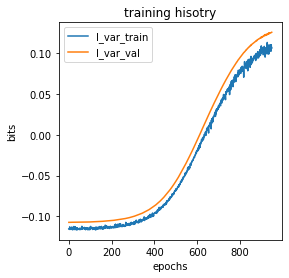

In [27]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
fig.savefig('pngs/Titeseq_MP/history.png',dpi=200,bbox_inches='tight')

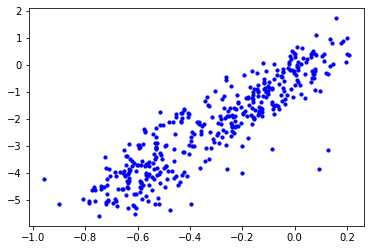

In [28]:
plt.scatter(theta_lc_init.ravel(),gpmap.weights[1].numpy().ravel(),c='blue',s=10)

In [29]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

# theta_0 = np.squeeze(gpmap.weights[1].numpy())[0]
# theta_0_df = pd.DataFrame(theta_0,columns=model.alphabet)

# theta_1 = np.squeeze(gpmap.weights[1].numpy())[1]
# theta_1_df = pd.DataFrame(theta_1,columns=model.alphabet)

In [30]:
phi = gpmap.x_to_phi(x_test)

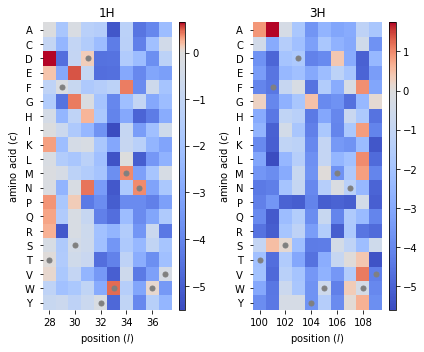

In [31]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/GP_map.png',dpi=200,bbox_inches='tight',facecolor='white')

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_74427/2877113002.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


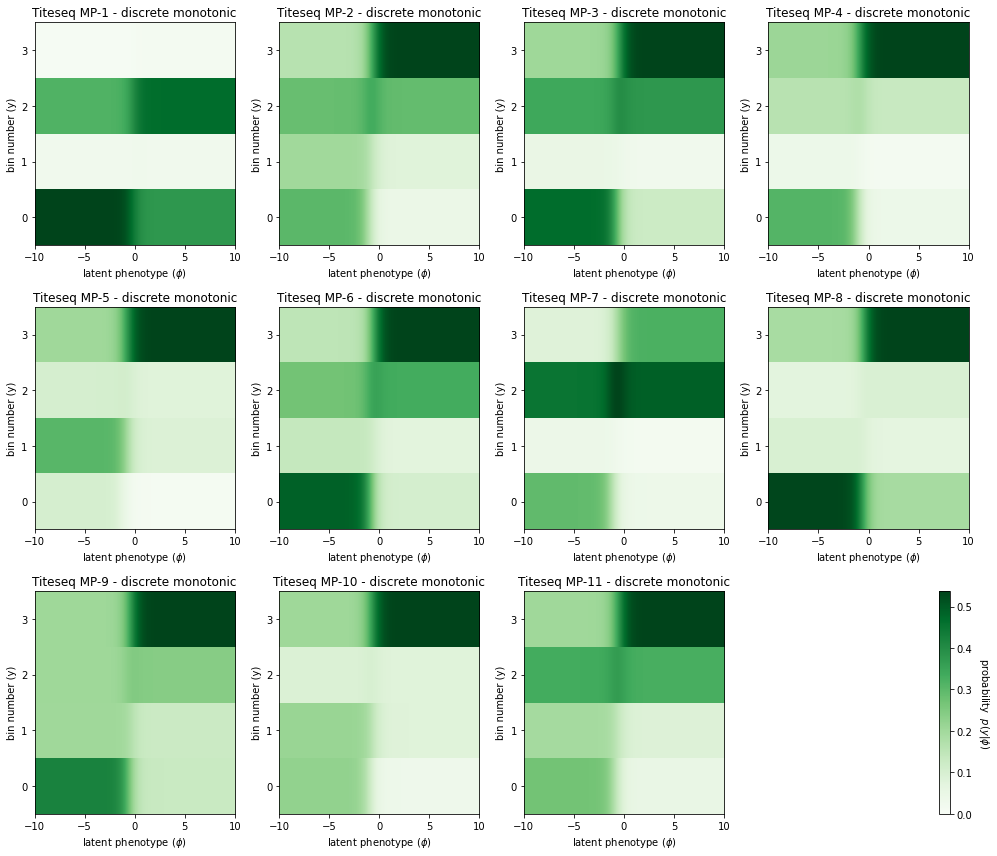

In [32]:
# Create grid in phi space
phi_lim = [-10, 10]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = TiteSeq_mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = TiteSeq_mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/Titeseq_MP/MPs.png',dpi=200,bbox_inches='tight')


In [33]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)

In [34]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [35]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [36]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

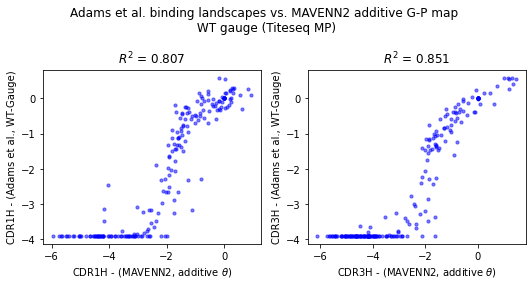

In [37]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_consensus_df.loc[0:9].values.ravel(),-CDR1H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR1H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_consensus_df.loc[10:20].values.ravel(),-CDR3H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR3H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge (Titeseq MP) ')
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_vs_mavenn_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [38]:
# np.save('models/theta_0_TS.npy',model.model.get_weights()[0])
# np.save('models/theta_lc_TS.npy',model.model.get_weights()[1])
# np.save('models/theta_lc_consensus_TS_df.npy', theta_lc_consensus_df.values)

In [39]:
#theta_lc_TS = np.load('models/theta_lc_consensus_TS_df.npy')
theta_lc_DM = np.load('models/theta_lc_consensus_DM_df.npy')



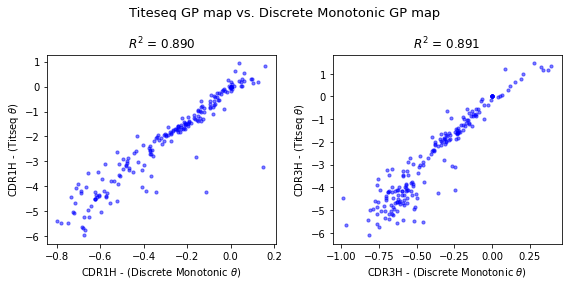

In [41]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]

Rsq = np.corrcoef(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR1H - (Titseq $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR3H - (Titseq $\\theta$)')

fig.suptitle('Titeseq GP map vs. Discrete Monotonic GP map',fontsize=13)
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Titeseq_vs_Discrete_mono_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')
